# Figures for the thesis
SIDE PLOTS
REAL SHIP DATA SAMPLING
FINAL BOX PLOTS

# Import Libraries

# 

In [2]:
import torch
import stable_baselines3
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import control as ct
from control import matlab
from scipy.signal import tf2zpk, zpk2tf, cont2discrete, TransferFunction
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle
from scipy.spatial.transform import Rotation as R

print("python version:", sys.version)
print("stable_baselines3 version:", stable_baselines3.__version__)
print("torch version:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
print("cuda version:", torch.version.cuda)
print("cudnn version:", torch.backends.cudnn.version())


## 

python version: 3.12.1 | packaged by conda-forge | (main, Dec 23 2023, 07:53:56) [MSC v.1937 64 bit (AMD64)]
stable_baselines3 version: 2.2.1
torch version: 2.2.0
cuda available: True
cuda version: 12.1
cudnn version: 8801


# 4th order transfer function

In [3]:
class VSQP_TF_4th:
    def __init__(self,
                 num_envs,
                 start_pos, 
                 time_step):

        self.pos = start_pos
        # self.states = np.array([self.random_init() for _ in range(num_envs)])
        self.dt  = time_step   
        self.updated_states_drone = np.zeros(9)
        self.num_envs = num_envs
        self.ax_lim = np.array([1,1,1])
        self.buffer_size = 4
        # self.updated_states = np.zeros_like(self.states)
        self.past_actions  = np.zeros((num_envs,self.buffer_size,3))

    def add_action(self, new_action):
         # Add the new action at the end of the buffer if there is space
        if self.past_actions.shape[1] < self.buffer_size:
            self.past_actions = np.append(self.past_actions, new_action[:, None, :], axis=1)
        else:
            # If buffer is full, remove the oldest (first) action and append the new action at the end
            self.past_actions = np.roll(self.past_actions, -1, axis=1)
            self.past_actions[:, -1, :] = new_action



    def acc_differentiation(self, actions):

        # self.past_actions = np.roll(self.past_actions, -1, axis=0)
        # self.past_actions[-1, :] = actions
        if self.past_actions.shape[1] < self.buffer_size:
            self.past_actions = np.append(self.past_actions, actions[:, None, :], axis=1)
        else:
            # If buffer is full, remove the oldest (first) action and append the new action at the end
            self.past_actions = np.roll(self.past_actions, -1, axis=1)
            self.past_actions[:, -1, :] = actions

        # Compute the first, second, and third derivatives of the actions using finite differences
        jerk = (self.past_actions[:, -1, :] - self.past_actions[:, -2, :]) / self.dt
        snap = (self.past_actions[:, -1, :] - 2 * self.past_actions[:, -2, :] + self.past_actions[:, -3, :]) / self.dt**2
        crackle = (self.past_actions[:, -1, :]- 3 * self.past_actions[:, -2, :] + 3 * self.past_actions[:, -3, :] - self.past_actions[:, -4, :]) / self.dt**3

        return jerk, snap, crackle


    def update(self, states, actions):
        # do not keep track of the updated states in this class
        # assume that max accelearions are in between -3 and 3
        ## de-normalize the acceleration
        # denorm_ax = (actions[:,0] + 1)/2*(self.ax_lim[0] + self.ax_lim[0]) - self.ax_lim[0]
        # denorm_ay = (actions[:,1] + 1)/2*(self.ax_lim[1] + self.ax_lim[1]) - self.ax_lim[1]
        # denorm_az = (actions[:,2] + 1)/2*(self.ax_lim[2] + self.ax_lim[2]) - self.ax_lim[2]
        de_acc = np.stack([actions[:,0], actions[:,1], actions[:,2]]).T
        # de_acc = np.stack([actions[0], actions[1], actions[2]]).T

        # # call differentiation to calculate the acc derivatives
        der1_acc, der2_acc, der3_acc = self.acc_differentiation(actions)
        # der1_acc = der1_acc.reshape(1,3)
        # der2_acc = der2_acc.reshape(1,3)
        # der3_acc = der3_acc.reshape(1,3)
        # de_acc = de_acc.reshape(1,3)

        # Anorth and Aeast
        der6_Y_ne = 793*de_acc[:, 0:2] + 203.6*der1_acc[:, 0:2] + 0.0008596*der2_acc[:, 0:2] + -9.477*10**-7*der3_acc[:, 0:2] - 19.89*states[:,15:17] - 139.5* states[:,12:14] - 633.2*states[:,9:11] - 793.2*states[:,6:8]
        # der6_Y_d = 318.9*de_acc[:,2] + 956.8*der1_acc[:,2] + 2870*der2_acc[:,2] + 678.6*der3_acc[:,2] - 24.42*states[:,23] - 223.6*states[:,20] - 1157*states[:,17] - 3030* states[:,14] - 1010*states[:,11] - 318.9*states[:,8]
        der6_Y_d =793*de_acc[:, 2] + 203.6*der1_acc[:, 2] + 0.0008596*der2_acc[:, 2] + -9.477*10**-7*der3_acc[:, 2] - 19.89*states[:,17] - 139.5* states[:,14] - 633.2*states[:,11] - 793.2*states[:,8]
        # der6_Y_d_reshape = der6_Y_d.reshape(1,-1)
        # combine both derivatives - use tf of the ne
        der4_Acc = np.column_stack((der6_Y_ne, der6_Y_d))
        # assume derivatives of u are zero
        updated_pos = states[:,0:3] + states[:,3:6]*self.dt
        updated_vel = states[:,3:6] + states[:,6:9]*self.dt
        updated_acc = states[:,6:9] + states[:,9:12]*self.dt # real acceleration response of the ac
        der_1 = states[:,9:12] + states[:,12:15]*self.dt
        der_2 = states[:,12:15] + states[:,15:18]*self.dt
        der_3 = states[:,15:18] + der4_Acc*self.dt


        # Accelerations to Euler Angles
        # pitch
        g = 9.81
        euler_angles = np.zeros_like(updated_acc)
        # if an >0
        euler_angles[updated_acc[:,0]>=0,1] = 0 
        # if an <0
        euler_angles[updated_acc[:,0]< 0,1] = np.arcsin(-updated_acc[updated_acc[:,0]<=0,1]/g)
        # euler_angles[updated_acc[:,0]< 0,1] = 0.5


        # roll
        euler_angles[:,0] = np.arcsin(updated_acc[:,1]/g)
        # euler_angles[:,0] = 0.5
        # psi - this is already done

        return updated_pos, updated_vel, updated_acc, der_1, der_2, der_3, euler_angles
    
    def reset_(self,num_reset):

        x0 = np.random.uniform(-0.1,0.1, size=(num_reset,)) + self.pos[0]
        y0 = np.random.uniform(-0.1,0.1, size=(num_reset,)) + self.pos[1]
        z0 = np.random.uniform(-0.1,0.1, size=(num_reset,)) + self.pos[2]
        
        vx0 = np.random.uniform(-0.1,0.1, size=(num_reset,))
        vy0 = np.random.uniform(-0.1,0.1, size=(num_reset,))
        vz0 = np.random.uniform(-0.1,0.1, size=(num_reset,))

        ax0 = np.random.uniform(-0.01,0.01, size=(num_reset,))
        ay0 = np.random.uniform(-0.01,0.01, size=(num_reset,))
        az0 = np.random.uniform(-0.01,0.01, size=(num_reset,))

        # euler angles
        phi0 = np.random.uniform(0,0, size=(num_reset,))
        the0 = np.random.uniform(0,0, size=(num_reset,))
        psi0 = np.random.uniform(0,0, size=(num_reset,))

        # Create an array of zeros with the shape (num_reset, 15) for the additional derivatives + 3 for the derivatives of accelerations
        zero_der_array = np.zeros((num_reset, 9))

        # Group them in threes (position, velocity, acceleration)
        # zero initial conditions
        positions = np.stack((x0, y0, z0), axis=-1)
        velocities = np.stack((vx0, vy0, vz0), axis=-1)
        accelerations = np.stack((ax0, ay0, az0), axis=-1)
        euler_angles = np.stack((phi0, the0, psi0), axis=-1)
        # Now, stack these groups along with the zero array to form the final state array
        stacked_states = np.hstack((positions, velocities, accelerations, zero_der_array, euler_angles))

        # modify it in a way that it includes the derivatives(zero given)
        # stacked_states = np.stack([x0, y0, z0, vx0, vy0, vz0,ax0, ay0, az0, zero_der_array ]).T
        return stacked_states

# Ship Platform(test cases)

In [27]:
class PlatformSimulator3D_test:
    def __init__(self, num_envs, start_amps, frequency, start_platform_pos):
        self.start_amps = start_amps  # p,phi,the,yaw
        self.edge_length = 5.0
        self.num_envs = num_envs
        # self.heading = 0.0  # Initial yaw angle in radians
        # self.pitch = 0.0  # Initial pitch angle in radians
        # self.roll = 0.0  # Initial roll angle in radians
        # self.time = 0.0  # Simulation time
        self.time = np.zeros(self.num_envs, dtype=float)
        #self.time = time[:, np.newaxis]
        self.dt = np.float32(0.1)
        # wave characteristics
        self.frequency = frequency

        self.amplitude_pos = self.start_amps[0:3] + np.random.uniform(-0.1,0.1, size= (self.num_envs,3))
        # self.frequency = self.frequency[0:3] + np.random.uniform(-0.001,0.001, size= (self.num_envs,3))
        self.frequency = self.frequency[0:3] +  np.random.uniform(0,0.001, size= (self.num_envs,3))
        self.frequency[:,0:2] = np.zeros((self.num_envs,2)) 
        self.start_platform_pos = start_platform_pos
        self.mix_frequency = 0.2
        self.rw_ts = 0.1 # random walk step size


    def update(self):

        self.prev_position = np.sin(self.time[:, np.newaxis] * self.frequency[:,0:3]) * self.amplitude_pos + self.start_platform_pos # Sinusoidal signal for 
        self.time += self.dt
    
        # Simple movement model with sinusoidal signals for position
        # reshape
        t = self.time[:, np.newaxis]
        self.position = np.sin(t * self.frequency[:,0:3]) * self.amplitude_pos + self.start_platform_pos # Sinusoidal signal for 
        
        # sum of sinusoidals for the z motion
        # self.position[:, 2] += np.sin(t * self.mix_frequency).reshape(self.num_envs,) * self.amplitude_pos[:, 2]  # Additional sinusoidal signal for the z-axis
        self.position[:, 2] += np.sin(t * self.mix_frequency).reshape(self.num_envs,) * (self.amplitude_pos[:, 2])  # Additional sinusoidal signal for the z-axis
        # random walk for the z motion
        random_steps = np.random.normal(0, self.rw_ts, size=(self.num_envs,))
        self.position[:,2] += random_steps

        ## apply a low pass filter
        alpha = 0.1
        self.position[:,2] = alpha * self.position[:,2] + (1-alpha)*self.prev_position[:,2]

        self.velocity = np.cos(t* self.frequency[:,0:3]) * self.amplitude_pos * self.frequency[:, 0:3]
        # will not consider the velocities for now
        # return states for all environments
        return self.position, self.velocity
    
    def reset_(self, num_reset):
        # 1st case all zero
        # wave characteristics
        ampx0 = self.start_amps[0] + np.random.uniform(-0.1,0.1, size= (num_reset,))
        ampy0 = self.start_amps[1] + np.random.uniform(-0.1,0.1, size= (num_reset,))
        ampz0 = self.start_amps[2] + np.random.uniform(-0.1,0.1, size= (num_reset,))

        px0 = np.sin(0) * ampx0 + self.start_platform_pos[0]
        py0 = np.sin(0) * ampy0 + self.start_platform_pos[1]
        pz0 = np.sin(0) * ampz0 + self.start_platform_pos[2]

        vx0 = np.cos(0) * ampx0 * self.frequency[0,0]
        vy0 = np.cos(0) * ampy0 * self.frequency[0,0]
        vz0 = np.cos(0) * ampz0 * self.frequency[0,0]

        stacked_states = np.stack([px0, py0, pz0, vx0, vy0, vz0]).T
        stacked_amps = np.stack([ampx0, ampy0, ampz0]).T
    
        
        return stacked_states, stacked_amps

# Plot the test case scenario

C:\Users\cnsyk\AppData\Local\Temp\ipykernel_23932\125152107.py:60: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(False, linestyle='-', alpha=0.1)


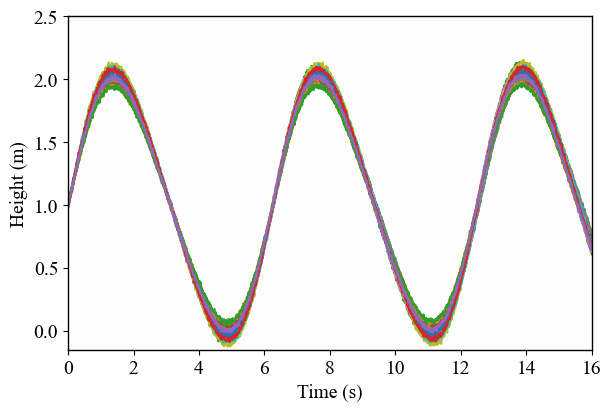

In [28]:
# plot the sinevawe
def sin_wave_z(num_envs):
    
    dt = 0.01
    list_Z = []
    time_Z = []

    
    start_platform_pos = np.array([0,0,-1])
    start_platform_att = np.array([0,0,0])
    dt = 0.01
    times = []
    z_positions = []
   

    # test case 1
    start_amps_t1 = np.array([50,2,1])
    freqs_t1 = np.array([0,0,0.05]) 

    # test case 2
    start_amps_t2 = np.array([50,2,-1])
    freqs_t2 = np.array([0,0,0.1]) 

    
    
    f = plt.figure(figsize=(6,4), layout="constrained")
    plt.rcParams["font.family"] = "Times New Roman"
    

    for i in range(num_envs):
        platform_simulator = PlatformSimulator3D_test(1, start_amps=start_amps_t2, frequency=freqs_t2, start_platform_pos=start_platform_pos)
        times = []
        z_positions = []
        for step in range(1600):  # 100 steps for 10 seconds, dt=0.1
            pos, vel = platform_simulator.update()
            times.append(platform_simulator.time[0]/10)  # Assuming time is the same for all envs, taking index 0
            z_positions.append(-pos[:, 2])  # Collect z-coordinates of all environments
        
        plt.plot(times,z_positions, label = i)

        list_Z.append(z_positions)
        time_Z.extend(times)


    # for zs, t in zip(list_Z, time_Z):
    #     plt.plot(t, -zs, label = 'env')
    
    # Setting the title and labels
    # plt.title('Ship vertical motion (test case)')
    # plt.xlabel('time (s)', fontsize=10)
    ax = plt.gca()  # Get current axes
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    # setting x-axis values
    labels = np.arange(0,15,0.01)
    plt.xlim([0, 16])
    plt.ylim([0, 2.5])

    # Adding grid and legend
    plt.grid(False, linestyle='-', alpha=0.1)
    #plt.legend(['ship vertical motion'])

    #
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(1)  # change width
        # ax.spines[axis].set_color('red')    # change color
    ax.set_facecolor('#fdfdfe')
    # Plot the updated acceleration (response)

    # plt.title('Step Input vs Updated Acceleration, dt = 0.01')
    plt.xlabel('Time (s)', fontsize=14)
    plt.ylabel('Height (m)', fontsize=14)
    plt.ylim(-0.15,2.5)
    plt.grid('True', alpha = 0.0)
    # plt.legend(loc = 'lower right',fontsize="12")
    # plt.xlim(-0.15,4)
    plt.tick_params(axis='both', which='major', labelsize=14)


    # Show plot
    f.savefig("ship_test_default.pdf", bbox_inches='tight')
    plt.show()



sin_wave_z(15)

# Plot training results

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# File paths
file_paths = [
    "v1_0.csv",
    "v2_0.csv",
    "v3_0.csv",
    "v4_0.csv",
    "v5_0.csv"
]

# Read CSV files and plot them
plt.figure(figsize=(10, 6))

for file_path in file_paths:
    # Read the CSV file
    df = pd.read_csv(file_path, header=None)
    # Plot the data
    plt.plot(df.iloc[:20, 1], df.iloc[:20, 2], label=file_path.split('/')[-1])

plt.xlabel('X Axis (2nd column)')
plt.ylabel('Y Axis (3rd column)')
plt.title('Plot of CSV Files')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2f}'))
plt.show()

# plt.xlabel('X Axis (2nd row)')
# plt.ylabel('Y Axis (3rd row)')
# plt.title('Plot of CSV Files')
# plt.legend()
# plt.grid(True)
# plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# File paths
file_paths = [
    "v1_0.csv",
    "v2_0.csv",
    "v3_0.csv",
    "v4_0.csv",
    "v5_0.csv"
]

# Read CSV files and plot them considering 2nd and 3rd columns
plt.figure(figsize=(10, 6))

for file_path in file_paths:
    # Read the CSV file
    df = pd.read_csv(file_path, header=None)
    # Plot the data
    plt.plot(df.iloc[:30, 1], df.iloc[:30, 2], label=file_path.split('/')[-1])

plt.xlabel('X Axis (2nd column)')
plt.ylabel('Y Axis (3rd column) [Log Scale]')
plt.yscale('log')
plt.title('Plot of CSV Files with Log-Scaled Y Axis')
plt.legend()
plt.grid(True)
plt.show()



# Gym environment for the landing scenario (original)

In [5]:
from gymnasium import spaces
from numpy import ndarray
from stable_baselines3.common.vec_env import VecEnv

# Assume no information regarding the attitude of the drone is available

class VSQP_ship_landing(VecEnv):
    def __init__(self, 
                 num_envs: int,
                 start_drone_pos,
                 start_platform_pos,
                 dt,
                 start_amps,
                 freqs
                ):
        
        self.num_envs = num_envs
        ## Initialize the classes
        self.drone = VSQP_TF_4th(num_envs=num_envs, start_pos= start_drone_pos, time_step=dt)
        self.ship = PlatformSimulator3D_test(num_envs, start_amps, freqs, start_platform_pos)

        self.start_drone_pos = start_drone_pos
        self.start_platform_pos = start_platform_pos
        self.start_platform_att = start_platform_att
        
        # find the relative position of the drone wrt the platform in world coordinates
        self.drone_pos_rel_world = self.start_drone_pos - self.start_platform_pos
       

        # action space (acceleration commands)
        action_space = spaces.Box(low=-1, high = 1, shape =(3,))
        # observation space (in the platform's reference frame, includes relative positions and attitude)
        self.ship_state_len = 6 # pos[W], vel[W]
        # do not consider the ship velocity
        self.drone_state_len = 21 # pos[W], vel[W], acc[W] >>>> 24 15+9 24 for the 6th order, 12 for the 2nd order
        self.obs_state_len = 9 # rel_pos[P], rel_vel[P], acc[W] + 3 for the drone's rotation
        # Define the low and high bounds for each variable

        observation_space = spaces.Box(
            low  = np.array([-np.inf]*self.obs_state_len),
            high = np.array([ np.inf]*self.obs_state_len))
        
        VecEnv.__init__(self,num_envs, observation_space, action_space)

        # world state drone: pos[W], vel[W], acc[W]
        self.world_states_drone = np.zeros((num_envs, self.drone_state_len), dtype =np.float32)
        # world state platform: pos[W], vel[W], att[W]
        self.world_states_ship = np.zeros((num_envs,self.ship_state_len), dtype = np.float32)
        # observation state
        self.states = np.zeros((num_envs,self.obs_state_len), dtype = np.float32)
        # max number of steps in an episode
        self.max_steps = 1000
        self.dt = np.float32(dt)

        self.step_counts = np.zeros(num_envs,dtype=int )
        self.actions = np.zeros((num_envs,3), dtype=np.float32)
        self.dones = np.zeros(num_envs,dtype=bool)
        
        self.update_states = self.update_states_platform

        self.pause = False
        
    def rotation_matrix(self,att):
        phi, the, psi = att
        Rz = np.array([
            [np.cos(psi), -np.sin(psi), 0],
            [np.sin(psi), np.cos(psi), 0],
            [0, 0, 1]])

        Ry = np.array([
            [np.cos(the), 0, np.sin(the)],
            [0, 1, 0],
            [-np.sin(the), 0, np.cos(the)]])

        Rx = np.array([
            [1, 0, 0],
            [0, np.cos(phi), -np.sin(phi)],
            [0, np.sin(phi), np.cos(phi)]])

        # Combine rotations
        R = Rz @ Ry @ Rx
        return R
      
    def rotation(self, eulers):
        self.rotation_matrices = []
        for att in eulers:
            R = self.rotation_matrix(att)
            self.rotation_matrices.append(R)
        return np.array(self.rotation_matrices)

    def update_states_platform(self):

        # new state array
        new_states = np.zeros((self.num_envs, self.obs_state_len), dtype = np.float32)
        
        # update relative positions
        rel_pos_in_plat_frame = self.world_states_drone[:,0:3] - self.world_states_ship[:,0:3]
        new_states[:,0:3] = rel_pos_in_plat_frame
      
        # update relative velocities
        rel_vel_in_plat_frame = self.world_states_drone[:,3:6] - self.world_states_ship[:,3:6]
        new_states[:,3:6] = rel_vel_in_plat_frame

        # update acc
        new_states[:,6:9] = self.world_states_drone[:,6:9]

        # assign the new states to states
        self.states = new_states

    def reset_(self, dones):
        num_reset = dones.sum()
        # reset both the drone and the platform
        stacked_ship, stacked_amps = self.ship.reset_(num_reset)
        stacked_drone = self.drone.reset_(num_reset)

        self.world_states_drone[dones] = stacked_drone
        self.world_states_ship[dones] = stacked_ship
        self.ship.amplitude_pos[dones] = stacked_amps[:,0:3]
        self.step_counts[dones] = np.zeros(num_reset)
        self.ship.time[dones] = np.zeros(num_reset) 
        
        # update states
        self.update_states()
        return self.states
    
    def reset(self): # this initializes the whole thing
        return self.reset_(np.ones(self.num_envs, dtype = bool))
    
    def step_async(self, actions):
        self.actions = actions

    def step_wait(self):

        # call the update fcns from the classes
        pos_drone_new, vel_drone_new, acc_drone_new, der_1, der_2, der_3, euler_angles = self.drone.update(self.world_states_drone, self.actions) 
        # pos_drone_new, vel_drone_new, acc_drone_new, euler_angles, der_1 = self.drone.update(self.world_states_drone, self.actions)
        pos_plat_new, vel_plat_new = self.ship.update()
        pos_drone_old = self.world_states_drone[:,0:3]
        pos_plat_old = self.world_states_ship[:,0:3]
        vel_plat_old = self.world_states_ship[:,3:6]
        vel_drone_old = self.world_states_drone[:,3:6]
        drone_pos_rel_new = pos_drone_new - pos_plat_new
        # # rehape for the transformation
        drone_pos_rel_local = drone_pos_rel_new

        # drone_pos_rel_local_ = self.rot_matrix_array.T @ drone_pos_rel_new.T # (3,3)x(3,10) Transform to platform's frame
        # drone_pos_rel_local = drone_pos_rel_local_.T
        # concatenate
        new_states_drone = np.concatenate((pos_drone_new, vel_drone_new, acc_drone_new, der_1, der_2, der_3, euler_angles), axis = 1)
     
        
        new_states_ship = np.concatenate((pos_plat_new, vel_plat_new), axis = 1)
        
        # ---------------- REWARD FUNCTION ---------------- #
        # ---------1. Distance to the platform------------- #
        # d2g_old = np.linalg.norm(pos_drone_old - pos_plat_old, axis = 1)
        # d2g_new = np.linalg.norm(pos_drone_new - pos_plat_new, axis = 1)
        # v2g_old = np.linalg.norm(vel_drone_old - vel_plat_old, axis = 1)
        # v2g_new = np.linalg.norm(vel_drone_new - vel_plat_new, axis =1)

        # vertical and horizontal distances
        d2g_old_v = np.abs(pos_drone_old[:,2] - pos_plat_old[:,2])
        d2g_new_v = np.abs(pos_drone_new[:,2] - pos_plat_new[:,2] )
        d2g_old_h = np.linalg.norm(pos_drone_old[:,:2] - pos_plat_old[:,:2], axis = 1 )
        d2g_new_h = np.linalg.norm(pos_drone_new[:,:2] - pos_plat_new[:,:2], axis = 1 )

        # vertical and horizontal velocities
        v2g_old_v = np.abs(vel_drone_old[:,2] - vel_plat_old[:,2])
        v2g_new_v = np.abs(vel_drone_new[:,2] - vel_plat_new[:,2])
        v2g_old_h = np.linalg.norm(vel_drone_old[:,:2] - vel_plat_old[:,:2], axis = 1 )
        v2g_new_h = np.linalg.norm(vel_drone_new[:,:2] - vel_plat_new[:,:2], axis = 1 )

        # Calculate velocity-based rewards as before
        #rewards = (d2g_old-d2g_new)  + 2*(v2g_old - v2g_new)

        # rewards = (d2g_old-d2g_new)  + 5*(v2g_old - v2g_new)
        # rewards = (d2g_old - d2g_new)*(-pos_drone_new[:,2]/10) + (v2g_old - v2g_new)*((10 + pos_drone_new[:,2])/10) 16
        # rewards = (d2g_old - d2g_new)*(-pos_drone_new[:,2]/10) + 10*(v2g_old - v2g_new)*((10 + pos_drone_new[:,2])/10)   # 17
        #rewards = (d2g_old - d2g_new) 
        # rewards = (d2g_old - d2g_new)*(-pos_drone_new[:,2]/10) + 5*(v2g_old - v2g_new)*((10 + pos_drone_new[:,2])/10) # 28
        # pos_reward = 1*(d2g_old_v - d2g_new_v)*(-pos_drone_new[:,2]/10) + 1*(d2g_old_h - d2g_new_h)*(-pos_drone_new[:,2]/10)
        # vel_reward = 2*(v2g_old_v - v2g_new_v)*((10 + pos_drone_new[:,2])/10) + 1*(v2g_old_h - v2g_new_h)*((10 + pos_drone_new[:,2])/10) # 30-31
        # rewards = 5*(d2g_old_v - d2g_new_v)*(-pos_drone_new[:,2]/10) + 1*(d2g_old_h - d2g_new_h)*(-pos_drone_new[:,2]/10) + ...
        # 5*(v2g_old_v - v2g_new_v)*((10 + pos_drone_new[:,2])/10) + 1*(v2g_old_h - v2g_new_h)*((10 + pos_drone_new[:,2])/10)
        pos_reward = 2*(d2g_old_v - d2g_new_v) + 1*(d2g_old_h - d2g_new_h)
        vel_reward = 2*(v2g_old_v - v2g_new_v)*((10 + pos_drone_new[:,2])/10) + 1*(v2g_old_h - v2g_new_h)*((10 + pos_drone_new[:,2])/10)
        rewards = pos_reward + vel_reward

        # # rewards = 5*(d2g_old[:,2] - d2g_new[:,2]) + (d2g_old[:,:2] - d2g_new[:,:2]) 
        # # platform going down
        # plat_up = vel_plat_new[:,2] > 0
        # plat_down = vel_plat_new[:,2] < 0
        # rewards[plat_up] = (vel_plat_new[plat_up,2]  + vel_drone_new[plat_up,2])*((10 + pos_drone_new[plat_up,2])/10)

        # rewards[plat_down] = -(vel_plat_new[plat_down,2] + vel_drone_new[plat_down,2])*((10 + pos_drone_new[plat_down,2])/10)


            # Height condition: only give rewards where height is greater than or equal to -10
        height_condition = pos_drone_new[:, 2] >= -10

        # Apply the condition to the rewards
          # This will zero out rewards where the condition is not met
        rewards *= height_condition.astype(int)

        # # check out of bounds
        out_of_bounds = np.any(np.abs(pos_drone_new) > 20, axis = 1)
        # rewards[out_of_bounds] = -10


        # # # check number of steps
        max_steps_reached = self.step_counts >= self.max_steps
        ground_is_collision = pos_drone_new[:,2] > 0
        #rewards[ground_is_collision] = -10


         # 3. Platform passed/collision occured
        normal_local = np.array([0, 0, 1])  # Normal in platform's local frame
        normal_local = np.tile(normal_local, (self.num_envs, 1))  # This creates a 5x3 array
        #normal_global = self.rot_matrix_array @ normal_local  # Transform to global frame ??
        normal_global = normal_local
        # Calculate perpendicular distance from the drone to the platform along the platform's normal
        # distance_to_platform =  drone_pos_rel_new @ normal_global
        distance_to_platform = np.einsum('ij,ij->i', drone_pos_rel_new, normal_global)
        platform_size = np.array([2,2])
        # check if the drone is within the platform's bounds and close to the surface
        collision_threshold = 0.1 # this can be determined according to the drone body
        # is_within_bounds = abs(drone_pos_rel_local[:,0]) <= platform_size[0] and \
        #                     abs(drone_pos_rel_local[:,1]) <= platform_size[1]
        is_within_bounds = np.logical_and(abs(drone_pos_rel_local[:,0]) <= platform_size[0],abs(drone_pos_rel_local[:,1]) <= platform_size[1])
        # this is only for representing the collision with the landing platform 
        is_collision_altitude = abs(distance_to_platform) <= collision_threshold
        is_colliding = np.logical_and(is_within_bounds, is_collision_altitude)
       
        # rewards[is_colliding] = -10

        # # assign velocity reward 
        # collision_indices = np.where(is_colliding)[0]
        # min_length = min(len(collision_indices), len(vel_drone_new))

        # Assign values to the rewards array at the collision indices
        # case 3: rewards[collision_indices[:min_length]] = -10 * vel_drone_new[:min_length, 2]
        # case 9: rewards[collision_indices[:min_length]] = -10 * v2g_new[:min_length] 
        # case 12: rewards[collision_indices[:min_length]] = -2 * v2g_new[:min_length] 
        # case 14: rewards[collision_indices[:min_length]] = -v2g_new[:min_length]**2 
        # case 15: rewards[collision_indices[:min_length]] = -5*v2g_new[:min_length] 
        # rewards[collision_indices[:min_length]] = -100*abs(np.rad2deg(roll_ship_new[:min_length]) + -100*abs(pitch_ship_new[:min_length]))
        # EULER ANGLES
        # rewards[collision_indices[:min_length]] = -np.rad2deg(roll_ship_new[:min_length])**2 - np.rad2deg(roll_ship_new[:min_length])**2
        # rewards[collision_indices[:min_length]] = -(roll_ship_new[:min_length])/30 + ((pitch_ship_new[:min_length])/45))

        #  # 1. soft landing
        # soft_landing = (v2g_new < 0.5) & is_colliding
        # rewards[soft_landing] = 10

        # # 2. hard landing
        # hard_landing = (v2g_new > 0.5) & is_colliding
        # rewards[hard_landing] = -10

        plat_up = vel_plat_new[:,2] < 0
        plat_down = vel_plat_old[:,2] > 0

        # des_land_cond = plat_down & is_colliding
        # undes_land_cond =  plat_up & is_colliding

        rewards[is_colliding] =  -vel_drone_new[is_colliding,2]**2 - 10*vel_plat_new[is_colliding,2]**2
        # rewards[undes_land_cond] =  np.multiply( vel_drone_new[des_land_cond,2]**2 ,vel_plat_new[des_land_cond,2])

        # dones (done condition is only related to the behaviour of the drone)
        # 1. collision with the platform is not considered
        dones = max_steps_reached | out_of_bounds | ground_is_collision | is_colliding
        # dones = max_steps_reached  | is_colliding
        self.dones = dones

        # Pause if collision
        if self.pause:
            dones = dones & ~dones
            self.dones = dones
        else:
            self.world_states_drone = new_states_drone
            self.world_states_ship = new_states_ship
            # reset env if done (and update states)
            self.reset_(dones)
        # Write info dicts
        infos = [{}] * self.num_envs
        for i in range(self.num_envs):
            # if dones[i]:
            #     infos[i]["terminal_observation"] = self.states[i]
            if max_steps_reached[i]:
                infos[i]["TimeLimit.truncated"] = True
            if is_colliding[i]:
                infos[i]["platform_collision"] = True
            if out_of_bounds[i]:
                infos[i]["out_of_bounds"] = True
            if ground_is_collision[i]:
                infos[i]["ground_collision"] = True
        return self.states, rewards, dones, infos

    def close(self):
        pass

    def seed(self, seed = None):
        pass
    def get_attr(self, attr_name, indices=None):
        raise AttributeError()

    def set_attr(self, attr_name, value, indices=None):
        pass

    def env_method(self, method_name, *method_args, indices=None, **method_kwargs):
        pass

    def env_is_wrapped(self, wrapper_class, indices=None):
        return [False]*self.num_envs

    def render(self, mode = 'human'):
        # outputs a dict containing all information for rendering
        state_dict_drone = dict(zip(['xd', 'yd', 'zd', 'vxd', 'vyd', 'vzd', 'ax', 'ay', 'az' ], self.world_states_drone[:,0:9].T))
        state_dict_drone_att = dict(zip(['phid', 'thed', 'psid'], self.world_states_drone[:,18:21].T))
        state_dict_ship = dict(zip(['xs', 'ys', 'zs','vxs', 'vys', 'vzs' ], self.world_states_ship.T))
        # rescale actions to [0,1] for rendering
        action_dict = dict(zip(['axc', 'ayc', 'azc'], (np.array(self.actions.T))))
        return {**state_dict_drone, **state_dict_drone_att, **state_dict_ship, **action_dict}



In [1]:
import os
from stable_baselines3 import PPO
from datetime import datetime
from stable_baselines3.common.vec_env import VecMonitor
import importlib
from quadcopter_animation import animation_VSQP

def animate_policy(model, env, deterministic=False, log_times=False, **kwargs):
    env.reset()
    def run():
        actions, _ = model.predict(env.states, deterministic=deterministic)
        states, rewards, dones, infos = env.step(actions)
        # print('states', states, 'rewards', rewards)
        if log_times:
            if rewards[0] == 10:
                print(env.step_counts[0]*env.dt)
        return env.render()
    animation_tez.view(run, **kwargs)


# Simulate PPO Models

V1

In [18]:
import importlib
import os
from quadcopter_animation import animation_tez
import matplotlib.pyplot as plt
importlib.reload(animation_tez)


# Initiate the states
start_drone_pos = np.array([0,0,-5])
start_platform_pos = np.array([0,0,-1])
start_platform_att = np.array([0,0,0])
dt = 0.01
start_amps = np.array([50,2,1, 30,45, 0])
freqs = np.array([0,0,0.03,0,0,0])

# test case 2
start_amps_t2 = np.array([50,2,-1])
freqs_t2 = np.array([0,0,0.05]) 

test_env = VSQP_ship_landing(num_envs=2,
                             start_drone_pos= start_drone_pos,
                             start_platform_pos=start_platform_pos,
                             dt=0.01, 
                             start_amps=start_amps_t2, 
                             freqs=freqs_t2)

# path = 'models/RL_ship_landing/RL_ship_landing_v28/5000000'
path = 'models/reward_1/v5/12000000'
# path = 'models/reward_1/v4/7000000'

model = PPO.load(path)
animate_policy(model, test_env, deterministic=False, log_times=True)

recording started
recording ended
recording saved in output_z_mix.mp4


# Logging (Multiple)

In [317]:

def run(num_env):
    test_env.max_steps = 10000
    test_env.reset()
    n_e = num_env

    # empty lists 
    time = []
    states_drone = []
    states_ship = []
    action_list = []
    states_RL = []
    done = False
    while not done:
        actions, _ = model.predict(test_env.states, deterministic= False)
        states, rewards, done, infos = test_env.step(actions)
        if done:
            break
        states_RL.append(states[0].copy())
        states_drone.append(test_env.world_states_drone[0].copy())
        states_ship.append(test_env.world_states_ship[0].copy())
        action_list.append(actions[0].copy())
        time.append(test_env.ship.time[0].copy())
        # time.append(test_env.step_counts[0]*test_env.dt)
    print('Simulation for the env', num_env,'completed!', 'time', len(time), 'info', infos)
    make_logdict(states_RL, states_drone, states_ship, action_list, time, n_e)


def make_logdict(states_RL, states_drone, states_ship, action_list, time, num_env):

    # make log dict
    log_dict = {}

    # convert them into numpy arrays
    states_RL_array = np.array(states_RL)
    states_drone_array = np.array(states_drone)
    states_ship_array = np.array(states_ship)
    actions_array = np.array(action_list)
    time_array = np.array(time)

    # time
    log_dict['t'] = time_array

    # states RL framework

    # Handle RL states: assuming each state component is stored in separate list entries
    log_dict['s1'] = states_RL_array[:,0]
    log_dict['s2'] = states_RL_array[:,1]
    log_dict['s3'] = states_RL_array[:,2]
    log_dict['s4'] = states_RL_array[:,3]
    log_dict['s5'] = states_RL_array[:,4]
    log_dict['s6'] = states_RL_array[:,5]
        

    # states drone
    log_dict['xd'] = states_drone_array[:,0]
    log_dict['yd'] = states_drone_array[:,1]
    log_dict['zd'] = states_drone_array[:,2]
    log_dict['vnd'] = states_drone_array[:,3]
    log_dict['ved'] = states_drone_array[:,4]
    log_dict['vdd'] = states_drone_array[:,5]
    log_dict['and'] = states_drone_array[:,6]
    log_dict['aed'] = states_drone_array[:,7]
    log_dict['add'] = states_drone_array[:,8]
    log_dict['phid'] = states_drone_array[:,18]
    log_dict['thed'] = states_drone_array[:,19]
    log_dict['psid'] = states_drone_array[:,20]

    # states ship
    log_dict['xs'] = states_ship_array[:,0]
    log_dict['ys'] = states_ship_array[:,1]
    log_dict['zs'] = states_ship_array[:,2]
    log_dict['vns'] = states_ship_array[:,3]
    log_dict['ves'] = states_ship_array[:,4]
    log_dict['vds'] = states_ship_array[:,5]

    # actions 
    log_dict['u1'] = actions_array[:,0]
    log_dict['u2'] = actions_array[:,1]
    log_dict['u3'] = actions_array[:,2]
    log_dict['u'] = np.stack([log_dict['u1'], log_dict['u2'], log_dict['u3']], axis=1)

    # save log dict 
    # save log dict to flight_data/simulation_logs
    # make folder
    name = '10' + '_' + str(num_env)
    folder = 'flight_data/paper_sims/reward_v26'
    if not os.path.exists(folder):
        os.makedirs(folder)
    # save dict as npz
    np.savez(folder + '/' + name, **log_dict)
    print('dict saved!')

# Run policies

In [ ]:
global num_env
num_envs = 100
for i in range(num_envs):
    test_env.reset()
    run(num_env=i)
    

# Load the dicts

In [319]:
num_envs = 100
logs = {}

# base path
base_path = 'flight_data/paper_sims/reward_v26/'
num_sim = 10
log_name = 'log_v26_10'

for i in range(num_envs):
    file_name = f'{num_sim}_{i}.npz'
    full_path = f'{base_path}{file_name}'

    logs[f'log_name{i}'] = dict(np.load(full_path))


# # List of log names
# log_names = [
#     'log_v17_8',
#     'log_v22_10',
#     'log_v21_7',
#     'log_v23_10',
#     'log_v18_12',
#     'log_v26_10',
# ]



# Plot the state variables

Position and Velocity

In [ ]:
def plot_vel_pos(log_dict):
    
    dt = 0.1
    # Extract data
    pnd, ped, pdd = log_dict['xd'], log_dict['yd'], log_dict['zd']
    vnd, ved, vdd = log_dict['vnd'], log_dict['ved'], log_dict['vdd']
    # time = log_dict['t']
   
     # Create the time array
    time = np.arange(0, len(pnd)*dt , dt)

    titles = ['Position in NED', 'Velocity in NED' ]
    labels = [(' p_n', 'p_e', 'p_d'), ('vn', 've', 'vd'), ('pns', 'pes', 'pds')]
    data_pairs = [(pnd, ped, pdd), (vnd, ved, vdd)]
    colors = ['red', 'blue', 'green']

    for i, ((p1, p2, p3), color, label) in enumerate(zip(data_pairs, colors, labels), 1):
        plt.subplot(3,1,i)
        plt.plot(time, p1, color = colors[0], linestyle = '--', linewidth = 1.5, label =label[0] )
        plt.plot(time, p2, color = colors[1], linewidth = 1.5, label = label[1])
        plt.plot(time, p3, color = colors[2], linewidth = 1.5, label = label[2])
        plt.xlabel('Time (s)', fontsize = 10)
        plt.ylabel(labels[i-1], fontsize = 10)
        plt.grid(True, linestyle = '--', alpha = 0.5)
        plt.legend()
        

    plt.tight_layout()
    plt.show()

# plot the sinevawe
def sin_wave_z(num_envs,log_name):
    
    dt = 0.01
    list_Z = []
    time_Z = []

    for i in range(num_envs):
        dict = logs[f'log_name{i}']
        list_Z.append(dict['zs'])
        time_Z.append(dict['t']/10)
        # time = np.arange(0, len(dict['zs'])*dt , dt)
        # time_Z.append(time)

    plt.figure(figsize=(10,6))
    for zs, t in zip(list_Z, time_Z):
        plt.plot(t, -zs, label = 'env')
    
    # Setting the title and labels
    plt.title('Position in NED - z_s (m)')
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('z_s (m)', fontsize=10)

    # Adding grid and legend
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()

    # Show plot
    plt.show()

sin_wave_z(num_envs=10, log_name=log_name)

num_envs = 15

# fig = plt.figure(figsize=(10,4))
# for i in range(num_envs):
#     log_plot_dict = logs[f'log_v37_12{i}']
#     plot_vel_pos(log_plot_dict)

In [302]:
reward_rel_vel_z_list_eva = []
reward_time_to_col_list_eva = []
reward_dev_center_list_eva = []

# Compute mean velocity, time to collision, deviation from the center


In [320]:
def land_parameters(num_envs,log_name):
    # initiate the summations
    sum_rel_vel_z = 0
    sum_time_to_col = 0
    sum_dev_center_xy = 0

    # initiate the lists
    rel_vel_z_list = []
    time_to_col_list = []
    dev_center_xy_list = []
    for i in range(num_envs):
        data_z = np.abs(logs[f'log_name{i}']['s6'][-1])
        data_t = logs[f'log_name{i}']['t'][-1]/10
        data_xy = np.sqrt(logs[f'log_name{i}']['s1'][-1]**2 + logs[f'log_name{i}']['s2'][-1]**2)
        sum_rel_vel_z +=  data_z
        sum_time_to_col += data_t
        sum_dev_center_xy += data_xy

        # append
        rel_vel_z_list.append(data_z)
        time_to_col_list.append(data_t)
        dev_center_xy_list.append(data_xy)

    # calculate means
    mean_rel_vel_z = sum_rel_vel_z/num_envs
    mean_time_to_col = sum_time_to_col/num_envs
    mean_dev_center_xy = sum_dev_center_xy/num_envs

    return mean_rel_vel_z, mean_time_to_col, mean_dev_center_xy, rel_vel_z_list, time_to_col_list, dev_center_xy_list




mean_z, mean_time, mean_xy, rel_vel_list, time_to_col_list, dev_center_list = land_parameters(num_envs, log_name)
print('Touchdown velocity (m/s)', mean_z, 'Deviation from center (m)', mean_xy, 'Time to land (s)', mean_time)
print('max velocity', max(rel_vel_list), 'min velocity', min(rel_vel_list))
print('max dev', max(dev_center_list), 'min dev', min(dev_center_list))
print('max time', max(time_to_col_list), 'min time', min(time_to_col_list))
reward_rel_vel_z_list_eva.append(rel_vel_list) # vz
reward_time_to_col_list_eva.append(time_to_col_list) # vz
reward_dev_center_list_eva.append(dev_center_list) # vz


Touchdown velocity (m/s) 0.08117513663135469 Deviation from center (m) 1.1976561511137687 Time to land (s) 14.616000217795367
max velocity 0.3451714 min velocity 0.0069479933
max dev 10.723405622559671 min dev 0.7693018048703191
max time 31.01000046208501 min time 13.280000197887421


Save the parameters (training)

In [21]:
# reward lists
reward_rel_vel_z_list = []
reward_time_to_col_list = []
reward_dev_center_list = []

In [100]:
# append 
# 1st v5-13
# 2nd v1-4
# 3rd v2-12
# 4rd v3-11
# 5th v4-7
reward_rel_vel_z_list.append(rel_vel_list) # vz
reward_time_to_col_list.append(time_to_col_list) # dev
reward_dev_center_list.append(dev_center_list) # time

Save the parameters (evaulation)

In [297]:
reward_rel_vel_z_list_eva = []
reward_time_to_col_list_eva = []
reward_dev_center_list_eva = []

In [326]:
# v17-8 - k:10
# v22-10 - k:25
# v21-7 - k:50
# v23 -10 -k:75
# v18-12 - k:100
# v26 -10, k:125
# v27 -10, k:100
# v27 -10, k:100
reward_rel_vel_z_list_eva.append(rel_vel_list) # vz
reward_time_to_col_list_eva.append(time_to_col_list) # vz
reward_dev_center_list_eva.append(dev_center_list) # vz

In [325]:
rel_vel_list.remove(max(rel_vel_list))

save the lists

In [327]:
import pickle

def save_data(*args, filename='data.pkl'):
    with open(filename, 'wb') as file:
        pickle.dump(args, file)

def load_data(filename='data.pkl'):
    with open(filename, 'rb') as file:
        return pickle.load(file)


# Save data
# save_data(reward_rel_vel_z_list, reward_time_to_col_list, reward_dev_center_list, filename='test_training.pkl')
save_data(reward_rel_vel_z_list_eva, reward_time_to_col_list_eva, reward_dev_center_list_eva, filename='eva_training.pkl')

# Box plots

# load the data

In [31]:
import pickle

def load_data(filename='data.pkl'):
    with open(filename, 'rb') as file:
        return pickle.load(file)
# Load data
RL_test = load_data(filename='test_training.pkl')
RL_eva = load_data(filename='eva_training.pkl')
# data_pid = load_data(filename='my_data_pid.pkl')
# data_pid_smooth_abs = load_data(filename='pid_smooth_abs_mix.pkl')
# data_pid_smooth_rel = load_data(filename='pid_smooth_rel_mix.pkl')
# data_RL_final = load_data(filename='final_data.pkl')
# Unpack the loaded data back into variables
reward_vz_RL, reward_ttc_RL, reward_xy_RL = RL_test
reward_vz_RL_eva, reward_ttc_RL_eva, reward_xy_RL_eva = RL_eva
# reward_vz_pid, reward_xy_pid, reward_ttc_pid = data_pid 
# reward_vz_pid_smooth_abs , reward_xy_pid_smooth_abs , reward_ttc_pid_smooth_abs = data_pid_smooth_abs 
# reward_vz_pid_smooth_rel, reward_xy_pid_smooth_rel, reward_ttc_pid_smooth_rel = data_pid_smooth_rel 
# reward_vz_RL_final, reward_xy_RL_final, reward_ttc_RL_final = data_RL_final
# reward_ttc_pid = [x/100 for x in reward_ttc_pid]
# reward_ttc_pid_smooth_abs = [x/100 for x in reward_ttc_pid_smooth_abs]
# reward_ttc_pid_smooth_rel = [x/100 for x in reward_ttc_pid_smooth_rel]

# Training box plots

In [ ]:
def box_plot(data_Z, data_XY, data_T):
    
    # boxprops = dict(linestyle='-', linewidth=2)

    # create subplots
    fig, ax = plt.subplots(1,3, figsize = (15,6), constrained_layout = True)
      # Adding a general title for the entire figure
    fig.suptitle('a: intermediate position reward, b: intermediate velocity reward, c$_1$: relative collision penalty, c$_2$: absolute collision penalty ', fontsize=14, fontweight='bold')

    # Titles for the axes
    labels = ['v_z (m/s)', 'd_xy (m)', 'time (s)']


    # First box plot (velocity)
    ax[0].boxplot(data_Z[0], positions= [0], labels = ['a'], showfliers=False)
    ax[0].boxplot(data_Z[1], positions= [1], labels = ['a-' + 'c$_2$'], showfliers=False)
    ax[0].boxplot(data_Z[2], positions= [2], labels = ['a-' + 'c$_1$'], showfliers=False)
    ax[0].boxplot(data_Z[3], positions= [3], labels = ['a-' + 'b-' + 'c$_1$'], showfliers=False)
    ax[0].boxplot(data_Z[4], positions= [4], labels = ['a-' + 'b-' + 'c$_2$'], showfliers=False)
    # ax[0].boxplot(data_Z[5], positions= [5], labels = ['a-' + 'b-' + 'c$_2$'], showfliers=False)
    ax[0].set_title('velocity', fontweight = 'bold')
    ax[0].set_ylabel('v$_z$ (m/s)')
    ax[0].grid(True, alpha = 0.3)
    

    ax[1].boxplot(data_XY[0], positions= [0], labels = ['a'], showfliers=False)
    ax[1].boxplot(data_XY[1], positions= [1], labels = ['a-' + 'c$_2$'], showfliers=False)
    ax[1].boxplot(data_XY[2], positions= [2], labels = ['a-' + 'c$_1$'], showfliers=False)
    ax[1].boxplot(data_XY[3], positions= [3], labels = ['a-' + 'b-' + 'c$_1$'], showfliers=False)
    ax[1].boxplot(data_XY[4], positions= [4], labels = ['a-' + 'b-' + 'c$_2$'], showfliers=False)
    # ax[1].boxplot(data_XY[5], positions= [5], labels = ['a-' + 'b-' + 'c$_2$'], showfliers=False)
    ax[1].set_title('deviation', fontweight = 'bold')
    ax[1].set_ylabel('d$_{xy}$ (m)')
    ax[1].grid(True, alpha = 0.3)

    ax[2].boxplot(data_T[0], positions= [0], labels = ['a'], showfliers=False)
    ax[2].boxplot(data_T[1], positions= [1], labels = ['a-' + 'c$_2$'], showfliers=False)
    ax[2].boxplot(data_T[2], positions= [2], labels = ['a-' + 'c$_1$'], showfliers=False)
    ax[2].boxplot(data_T[3], positions= [3], labels = ['a-' + 'b-' + 'c$_1$'], showfliers=False)
    ax[2].boxplot(data_T[4], positions= [4], labels = ['a-' + 'b-' + 'c$_2$'], showfliers=False)
    # ax[2].boxplot(data_T[5], positions= [5], labels = ['a-' + 'b-' + 'c$_2$'], showfliers=False)
    ax[2].set_title('duration', fontweight = 'bold')
    ax[2].set_ylabel('t (s)')
    ax[2].grid(True, alpha = 0.3)

    

    # show plot
     # Show plot
    fig.savefig("training_box_plots.pdf", bbox_inches='tight')
    plt.show()

# LOAD RL data
data_z_list = []
data_xy_list = []
data_t_list = []


# append 
# 2nd v1-4 # only pos - 0
# 3rd v2-12 # pos + abs
# 4rd v3-11 # pos + rel
# 5th v4-7 # pos + vel + rel
# 1st v5-13 # pos + vel + abs


data_z_list.append(reward_vz_RL[1])
data_z_list.append(reward_vz_RL[2])
data_z_list.append(reward_vz_RL[3])
data_z_list.append(reward_vz_RL[4])
data_z_list.append(reward_vz_RL[0])


data_t_list.append(reward_ttc_RL[1])
data_t_list.append(reward_ttc_RL[2])
data_t_list.append(reward_ttc_RL[3])
data_t_list.append(reward_ttc_RL[4])
data_t_list.append(reward_ttc_RL[0])


data_xy_list.append(reward_xy_RL[1])
data_xy_list.append(reward_xy_RL[2])
data_xy_list.append(reward_xy_RL[3])
data_xy_list.append(reward_xy_RL[4])
data_xy_list.append(reward_xy_RL[0])


box_plot(data_Z=data_z_list, data_XY=data_xy_list,data_T=data_t_list)

Compare the optimal one to the others

In [ ]:
def box_plot(data_Z, data_XY, data_T):
    
    # boxprops = dict(linestyle='-', linewidth=2)

    # create subplots
    fig, ax = plt.subplots(1,3, figsize = (15,6), constrained_layout = True)
      # Adding a general title for the entire figure
    fig.suptitle('a: intermediate position reward, b: intermediate velocity reward, c$_1$: relative collision penalty, c$_2$: absolute collision penalty ', fontsize=14, fontweight='bold')

    # Titles for the axes
    labels = ['v_z (m/s)', 'd_xy (m)', 'time (s)']


    # First box plot (velocity)
    ax[0].boxplot(data_Z[0], positions= [0], labels = ['a'], showfliers=False)
    ax[0].boxplot(data_Z[1], positions= [1], labels = ['a-' + 'c$_2$'], showfliers=False)
    ax[0].boxplot(data_Z[2], positions= [2], labels = ['a-' + 'c$_1$'], showfliers=False)
    ax[0].boxplot(data_Z[3], positions= [3], labels = ['a-' + 'b-' + 'c$_1$'], showfliers=False)
    ax[0].boxplot(data_Z[4], positions= [4], labels = ['a-' + 'b-' + 'c$_2$'], showfliers=False)
    # ax[0].boxplot(data_Z[5], positions= [5], labels = ['a-' + 'b-' + 'c$_2$'], showfliers=False)
    # coefficients
    ax[0].boxplot(data_Z[5], positions= [5], labels = ['k$_1$'], showfliers=False)
    ax[0].boxplot(data_Z[6], positions= [6], labels = ['k$_2$'], showfliers=False)
    ax[0].boxplot(data_Z[7], positions= [7], labels = ['k$_3$'], showfliers=False)
    ax[0].set_title('velocity', fontweight = 'bold')
    ax[0].set_ylabel('v$_z$ (m/s)')
    ax[0].grid(True, alpha = 0.3)
    

    ax[1].boxplot(data_XY[0], positions= [0], labels = ['a'], showfliers=False)
    ax[1].boxplot(data_XY[1], positions= [1], labels = ['a-' + 'c$_2$'], showfliers=False)
    ax[1].boxplot(data_XY[2], positions= [2], labels = ['a-' + 'c$_1$'], showfliers=False)
    ax[1].boxplot(data_XY[3], positions= [3], labels = ['a-' + 'b-' + 'c$_1$'], showfliers=False)
    ax[1].boxplot(data_XY[4], positions= [4], labels = ['a-' + 'b-' + 'c$_2$'], showfliers=False)
    # ax[1].boxplot(data_XY[5], positions= [5], labels = ['a-' + 'b-' + 'c$_2$'], showfliers=False)
    # coefficients
    ax[1].boxplot(data_XY[5], positions= [5], labels = ['k$_1$'], showfliers=False)
    ax[1].boxplot(data_XY[6], positions= [6], labels = ['k$_2$'], showfliers=False)
    ax[1].boxplot(data_XY[7], positions= [7], labels = ['k$_3$'], showfliers=False)
    ax[1].set_title('deviation', fontweight = 'bold')
    ax[1].set_ylabel('d$_{xy}$ (m)')
    ax[1].grid(True, alpha = 0.3)

    ax[2].boxplot(data_T[0], positions= [0], labels = ['a'], showfliers=False)
    ax[2].boxplot(data_T[1], positions= [1], labels = ['a-' + 'c$_2$'], showfliers=False)
    ax[2].boxplot(data_T[2], positions= [2], labels = ['a-' + 'c$_1$'], showfliers=False)
    ax[2].boxplot(data_T[3], positions= [3], labels = ['a-' + 'b-' + 'c$_1$'], showfliers=False)
    ax[2].boxplot(data_T[4], positions= [4], labels = ['a-' + 'b-' + 'c$_2$'], showfliers=False)
    # ax[2].boxplot(data_T[5], positions= [5], labels = ['a-' + 'b-' + 'c$_2$'], showfliers=False)
    # coefficients
    ax[2].boxplot(data_T[5], positions= [5], labels = ['k$_1$'], showfliers=False)
    ax[2].boxplot(data_T[6], positions= [6], labels = ['k$_2$'], showfliers=False)
    ax[2].boxplot(data_T[7], positions= [7], labels = ['k$_3$'], showfliers=False)
    ax[2].set_title('duration', fontweight = 'bold')
    ax[2].set_ylabel('t (s)')
    ax[2].grid(True, alpha = 0.3)

    

    # show plot
     # Show plot
    # fig.savefig("training_box_plots.pdf", bbox_inches='tight')
    plt.show()

# LOAD RL data
data_z_list = []
data_xy_list = []
data_t_list = []


# append 
# 2nd v1-4 # only pos - 0
# 3rd v2-12 # pos + abs
# 4rd v3-11 # pos + rel
# 5th v4-7 # pos + vel + rel
# 1st v5-13 # pos + vel + abs


data_z_list.append(reward_vz_RL[1])
data_z_list.append(reward_vz_RL[2])
data_z_list.append(reward_vz_RL[3])
data_z_list.append(reward_vz_RL[4])
data_z_list.append(reward_vz_RL[0])
# coefficients
data_z_list.append(reward_vz_RL_eva[0])
data_z_list.append(reward_vz_RL_eva[1])
data_z_list.append(reward_vz_RL_eva[2])

data_t_list.append(reward_ttc_RL[1])
data_t_list.append(reward_ttc_RL[2])
data_t_list.append(reward_ttc_RL[3])
data_t_list.append(reward_ttc_RL[4])
data_t_list.append(reward_ttc_RL[0])
# coefficients
data_t_list.append(reward_time_to_col_list_eva[0])
data_t_list.append(reward_time_to_col_list_eva[1])
data_t_list.append(reward_time_to_col_list_eva[2])

data_xy_list.append(reward_xy_RL[1])
data_xy_list.append(reward_xy_RL[2])
data_xy_list.append(reward_xy_RL[3])
data_xy_list.append(reward_xy_RL[4])
data_xy_list.append(reward_xy_RL[0])
# coefficients
data_xy_list.append(reward_xy_RL_eva[0])
data_xy_list.append(reward_xy_RL_eva[1])
data_xy_list.append(reward_xy_RL_eva[2])


box_plot(data_Z=data_z_list, data_XY=data_xy_list,data_T=data_t_list)

# Violin plots for coefficients

In [ ]:
def violin_plot(data_Z, data_XY, data_T):
    
    # boxprops = dict(linestyle='-', linewidth=2)

    # create subplots
    fig, ax = plt.subplots(1, figsize = (6,4), constrained_layout = True)
      # Adding a general title for the entire figure

# Customizing color palette
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    # Create violin plots with customized colors and increased width
    parts = ax.violinplot(data_Z, positions=np.arange(len(data_Z)), vert=False, showmeans=False, showmedians=True, widths=0.7)
    for pc, color in zip(parts['bodies'], colors):
      pc.set_facecolor(color)
      pc.set_edgecolor('black')
      pc.set_alpha(0.5)

      # The median lines are stored in 'cmedians' which is a LineCollection
    parts['cmedians'].set_edgecolor('yellow')  # Change median line color
    parts['cmedians'].set_linewidth(1)       # Set line width
    parts['cmedians'].set_linestyle('-')

      # Customizing the extrema lines (minima and maxima horizontal lines)
    # parts['cmaxes'], parts['cmins'] are used to access these lines
    parts['cmaxes'].set_color('black')  # Change max line color
    parts['cmins'].set_color('black')  # Change min line color

    #     # Optionally, if you also want to change the style of the lines:
    # parts['cmaxes'].set_linestyle('--')  # Set linestyle for max lines
    # parts['cmins'].set_linestyle(':')    # Set linestyle for min lines
        # Titles for the axes
    labels = ['v_z (m/s)', 'd_xy (m)', 'time (s)']


    # # First box plot (velocity)
    # ax.violinplot(data_Z[0], positions= [0], vert=False, showmeans=False, showmedians=True, widths=0.7)
    # ax.violinplot(data_Z[1], positions= [1], vert=False, showmeans=False, showmedians=True, widths=0.7)
    # ax.violinplot(data_Z[2], positions= [2], vert=False, showmeans=False, showmedians=True, widths=0.7)
    # ax.violinplot(data_Z[3], positions= [3], vert=False, showmeans=False, showmedians=True, widths=0.7)
    # ax.violinplot(data_Z[4], positions= [4], vert=False, showmeans=False, showmedians=True, widths=0.7)
    # ax[0].boxplot(data_Z[5], positions= [5], labels = ['a-' + 'b-' + 'c$_2$'], showfliers=False)
    ax.set_title('velocity', fontweight = 'bold')
    ax.set_xlabel('v$_z$ (m/s)')
    ax.set_ylabel('coefficients (k$_i$)')
    ax.grid(True,linestyle='-', alpha = 0.3)
    labels = ['k$_1$:10', 'k$_2$:25', 'k$_3$:50', 'k$_4$:75', 'k$_5$:100']
    ax.set_yticks(np.arange(0, 5), labels=labels)
    
    plt.show()

# LOAD RL data
data_z_list_coefs = []
data_xy_list_coefs = []
data_t_list_coefs = []


# coefficients
data_z_list_coefs.append(reward_vz_RL_eva[0])
data_z_list_coefs.append(reward_vz_RL_eva[3])
data_z_list_coefs.append(reward_vz_RL_eva[4])
data_z_list_coefs.append(reward_vz_RL_eva[5])
data_z_list_coefs.append(reward_vz_RL_eva[2])


# coefficients
data_t_list_coefs.append(reward_time_to_col_list_eva[0])
data_t_list_coefs.append(reward_time_to_col_list_eva[3])
data_t_list_coefs.append(reward_time_to_col_list_eva[4])
data_t_list_coefs.append(reward_time_to_col_list_eva[5])
data_t_list_coefs.append(reward_time_to_col_list_eva[2])


# coefficients
data_xy_list_coefs.append(reward_xy_RL_eva[0])
data_xy_list_coefs.append(reward_xy_RL_eva[3])
data_xy_list_coefs.append(reward_xy_RL_eva[4])
data_xy_list_coefs.append(reward_xy_RL_eva[5])
data_xy_list_coefs.append(reward_xy_RL_eva[2])


# v17-8 - k:10

# v21-7 - k:50
# v18-12 - k:100

# v22-10 - k:25
# v21 - 7 - k:50

# v23 -10 -k:75

violin_plot(data_Z=data_z_list_coefs, data_XY=data_xy_list,data_T=data_t_list)

# Mix up violin plots with the box plot 

In [32]:
# LOAD RL data
data_z_list = []
data_xy_list = []
data_t_list = []

# 
data_z_list.append(reward_vz_RL[1])
data_z_list.append(reward_vz_RL[2])
data_z_list.append(reward_vz_RL[3])
data_z_list.append(reward_vz_RL[4])
data_z_list.append(reward_vz_RL[0])
#
data_z_list.append(reward_vz_RL_eva[4])


data_t_list.append(reward_ttc_RL[1])
data_t_list.append(reward_ttc_RL[2])
data_t_list.append(reward_ttc_RL[3])
data_t_list.append(reward_ttc_RL[4])
data_t_list.append(reward_ttc_RL[0])
#
# data_t_list.append(reward_time_to_col_list_eva[4])
data_t_list.append(reward_ttc_RL_eva[4])

data_xy_list.append(reward_xy_RL[1])
data_xy_list.append(reward_xy_RL[2])
data_xy_list.append(reward_xy_RL[3])
data_xy_list.append(reward_xy_RL[4])
data_xy_list.append(reward_xy_RL[0])
#
data_xy_list.append(reward_xy_RL_eva[4])


# coefficients
# LOAD RL data
data_z_list_coefs = []


# coefficients
data_z_list_coefs.append(reward_vz_RL_eva[0])
data_z_list_coefs.append(reward_vz_RL_eva[1])
data_z_list_coefs.append(reward_vz_RL_eva[2])
data_z_list_coefs.append(reward_vz_RL_eva[3])
data_z_list_coefs.append(reward_vz_RL_eva[4])
# data_z_list_coefs.append(reward_vz_RL_eva[6]) # does not contain the max element
# data_z_list_coefs.append(reward_vz_RL_eva[5]) - same with 6th

data_xy_list_coefs = []


# coefficients
data_xy_list_coefs.append(reward_xy_RL_eva[0])
data_xy_list_coefs.append(reward_xy_RL_eva[1])
data_xy_list_coefs.append(reward_xy_RL_eva[2])
data_xy_list_coefs.append(reward_xy_RL_eva[3])
data_xy_list_coefs.append(reward_xy_RL_eva[4])
#data_xy_list_coefs.append(reward_xy_RL_eva[6]) # does not contain the max element
# data_z_list_coefs.append(reward_vz_RL_eva[5]) - same with 6th


data_t_list_coefs = []


# coefficients
data_t_list_coefs.append(reward_ttc_RL_eva[0])
data_t_list_coefs.append(reward_ttc_RL_eva[1])
data_t_list_coefs.append(reward_ttc_RL_eva[2])
data_t_list_coefs.append(reward_ttc_RL_eva[3])
data_t_list_coefs.append(reward_ttc_RL_eva[4])
# data_t_list_coefs.append(reward_ttc_RL_eva[6]) # does not contain the max element
# data_z_list_coefs.append(reward_vz_RL_eva[5]) - same with 6th

In [ ]:
import matplotlib.patches as patches

def box_plot(data_Z, data_XY, data_T, data_Z_eva):
    
    # boxprops = dict(linestyle='-', linewidth=2)

    # create subplots
    fig, ax = plt.subplots(1,4, figsize = (15,6), constrained_layout = True)
      # Adding a general title for the entire figure
    fig.suptitle('a: intermediate position reward, b: intermediate velocity reward, c$_1$: relative collision penalty, c$_2$: absolute collision penalty ', fontsize=14, fontweight='bold')

    # Titles for the axes
    labels = ['v_z (m/s)', 'd_xy (m)', 'time (s)']

    # # Adding a large purple circle on the 'final' position
    # circle_1 = patches.Circle((5, np.mean(data_Z[5])), 0.15, facecolor = '#9467bd', alpha = 0.3, edgecolor='#9467bd', linewidth = 2, linestyle = '-')
    # circle_2 = patches.Circle((5, np.mean(data_XY[5])), 0.15, facecolor = '#9467bd', alpha = 0.3,  edgecolor='#9467bd', linewidth = 2, linestyle = '-')
    # circle_3 = patches.Circle((5, np.mean(data_T[5])), 0.15, facecolor = '#9467bd', alpha = 0.3, edgecolor='#9467bd', linewidth = 2, linestyle = '-')
    
    # ax[0].add_patch(circle_1)
    # ax[1].add_patch(circle_2)
    # ax[2].add_patch(circle_3)


    
    # First box plot (velocity)
    ax[0].boxplot(data_Z[0], positions= [0], labels = ['a'], showfliers=False)
    ax[0].boxplot(data_Z[1], positions= [1], labels = ['a-' + 'c$_2$'], showfliers=False)
    ax[0].boxplot(data_Z[2], positions= [2], labels = ['a-' + 'c$_1$'], showfliers=False)
    ax[0].boxplot(data_Z[3], positions= [3], labels = ['a-' + 'b-' + 'c$_1$'], showfliers=False)
    ax[0].boxplot(data_Z[4], positions= [4], labels = ['a-' + 'b-' + 'c$_2$'], showfliers=False)
    ax[0].boxplot(data_Z[5], positions= [5], labels = ['final'], showfliers=False)
    ax[0].set_title('velocity', fontweight = 'bold')
    ax[0].set_ylabel('v$_z$ (m/s)')
    ax[0].grid(True, alpha = 0.3)
    
    ax[1].boxplot(data_XY[0], positions= [0], labels = ['a'], showfliers=False)
    ax[1].boxplot(data_XY[1], positions= [1], labels = ['a-' + 'c$_2$'], showfliers=False)
    ax[1].boxplot(data_XY[2], positions= [2], labels = ['a-' + 'c$_1$'], showfliers=False)
    ax[1].boxplot(data_XY[3], positions= [3], labels = ['a-' + 'b-' + 'c$_1$'], showfliers=False)
    ax[1].boxplot(data_XY[4], positions= [4], labels = ['a-' + 'b-' + 'c$_2$'], showfliers=False)
    ax[1].boxplot(data_XY[5], positions= [5], labels = ['final'], showfliers=False)
    ax[1].set_title('deviation', fontweight = 'bold')
    ax[1].set_ylabel('d$_{xy}$ (m)')
    ax[1].grid(True, alpha = 0.3)

  
    ax[2].boxplot(data_T[0], positions= [0], labels = ['a'], showfliers=False)
    ax[2].boxplot(data_T[1], positions= [1], labels = ['a-' + 'c$_2$'], showfliers=False)
    ax[2].boxplot(data_T[2], positions= [2], labels = ['a-' + 'c$_1$'], showfliers=False)
    ax[2].boxplot(data_T[3], positions= [3], labels = ['a-' + 'b-' + 'c$_1$'], showfliers=False)
    ax[2].boxplot(data_T[4], positions= [4], labels = ['a-' + 'b-' + 'c$_2$'], showfliers=False)
    ax[2].boxplot(data_T[5], positions= [5], labels = ['final'], showfliers=False)
    ax[2].set_title('duration', fontweight = 'bold')
    ax[2].set_ylabel('t (s)')
    ax[2].grid(True, alpha = 0.3)

    

    # Scatter plot overlay for max, min, and mean
    data_lists = [data_Z, data_XY, data_T]
    alpha_scatter = 0.2

    data_Z_max_index = [1,1,1,2,3]
    data_Z_min_index = [0,0,3,1,1]

    data_XY_max_index = [4,5,5,4,3]
    data_XY_min_index = [0,0,2,0,0]

    data_T_max_index = [1,4,4,4,3]
    data_T_min_index = [0,0,2,0,0]

    a_min = [data_Z_min_index, data_XY_min_index, data_T_min_index ]
    a_max = [data_Z_max_index, data_XY_max_index, data_T_max_index ]


    # for i in range(3):  # For each axis
    #     for k in range(len(data_lists[i])-1):  # Assume each list in data_lists contains sublists
    #           sorted_data = np.sort(data_lists[i][k])
    #           # Access max and min values based on provided indices for the current k-th dataset
    #           max_val = sorted_data[-a_max[i][k]]  # Access from end for max
    #           min_val = sorted_data[a_min[i][k]]  # Access from start for min

    #           # Placing scatter plots on the corresponding box plot positions
    #           ax[i].scatter(k, max_val, alpha=alpha_scatter, color = 'red')  # color for max
    #           ax[i].scatter(k, min_val, alpha=alpha_scatter, color = 'green')  # color for min
              



    ## VIOLIN PLOTS
    # Customizing color palette
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#17becf']
    
    # Create violin plots with customized colors and increased width
    parts = ax[3].violinplot(data_Z_eva, positions=np.arange(len(data_Z_eva)), vert=True, showmeans=False, showmedians=True, widths=0.7)
    for pc, color in zip(parts['bodies'], colors):
      pc.set_facecolor(color)
      pc.set_edgecolor('None')
      pc.set_alpha(0.3)

      # The median lines are stored in 'cmedians' which is a LineCollection
    parts['cmedians'].set_edgecolor('yellow')  # Change median line color
    parts['cmedians'].set_linewidth(1)       # Set line width
    parts['cmedians'].set_linestyle('-')

      # Customizing the extrema lines (minima and maxima horizontal lines)
    # parts['cmaxes'], parts['cmins'] are used to access these lines
    parts['cmaxes'].set_color('black')  # Change max line color
    parts['cmins'].set_color('black')  # Change min line color
    parts['cmaxes'].set_linewidth(1)    # Set line width for max horizontal lines
    parts['cmins'].set_linewidth(1)    # Set line width for max horizontal lines

    ax[3].set_title('velocity', fontweight = 'bold')
    ax[3].set_ylabel('v$_z$ (m/s)')
    ax[3].set_xlabel('coefficients (k$_i$)')
    ax[3].grid(True,linestyle='-', alpha = 0.2)
    labels = ['k$_1$:10', 'k$_2$:25', 'k$_3$:50', 'k$_4$:75', 'k$_5$:100', 'k$_6$:125']
    ax[3].set_xticks(np.arange(0, len(labels)), labels=labels)
    ax[3].set_ylim(0,0.3)

    # show plot
     # Show plot
    fig.savefig("box_violin_plots.pdf", bbox_inches='tight')
    plt.show()


box_plot(data_Z=data_z_list, data_XY=data_xy_list,data_T=data_t_list, data_Z_eva=data_z_list_coefs)

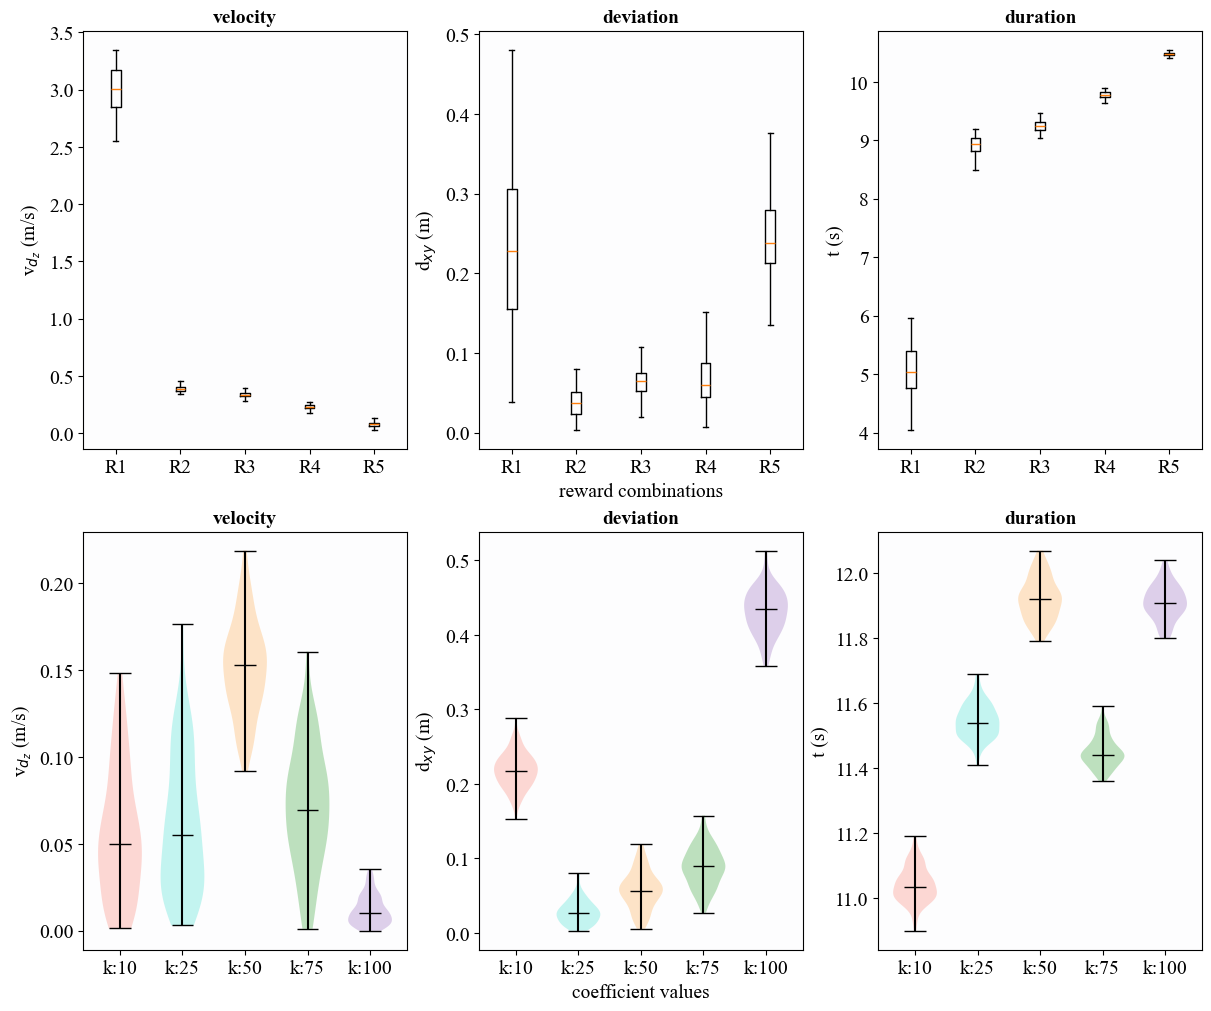

In [34]:
import matplotlib.patches as patches

def box_plot(data_Z, data_XY, data_T, data_Z_eva, data_XY_eva, data_T_eva):
    
  # boxprops = dict(linestyle='-', linewidth=2)

  # create subplots
  fig, ax = plt.subplots(2,3, figsize = (12,10), constrained_layout = True)
  plt.rcParams["font.family"] = "Times New Roman"
    # Adding a general title for the entire figure
  # fig.suptitle('a: intermediate position reward, b: intermediate velocity reward, c$_1$: relative collision penalty, c$_2$: absolute collision penalty ', fontsize=14, fontweight='bold')

  # Titles for the axes
  labels_ = ['v$_{d_z}$ (m/s)', 'd$_{xy}$ (m)', 't (s)']
  titles = ['velocity', 'deviation', 'duration']
  
  # First box plot (velocity)
  ax[0,0].boxplot(data_Z[0], positions= [0], labels = ['R1'], showfliers=False)
  ax[0,0].boxplot(data_Z[1], positions= [1], labels = ['R2'], showfliers=False)
  ax[0,0].boxplot(data_Z[2], positions= [2], labels = ['R3'], showfliers=False)
  ax[0,0].boxplot(data_Z[3], positions= [3], labels = ['R4'], showfliers=False)
  ax[0,0].boxplot(data_Z[4], positions= [4], labels = ['R5'], showfliers=False)
  # ax[0,0].boxplot(data_Z_eva[1], positions= [5], labels = ['final'], showfliers=False)
  #ax[0,0].set_title('velocity', fontweight = 'bold')
  # ax[0,0].set_ylabel('v$_z$ (m/s)')
  ax[0,0].grid(True, alpha = 0.3)
  
  ax[0,1].boxplot(data_XY[0], positions= [0], labels = ['R1'], showfliers=False)
  ax[0,1].boxplot(data_XY[1], positions= [1], labels = ['R2'], showfliers=False)
  ax[0,1].boxplot(data_XY[2], positions= [2], labels = ['R3'], showfliers=False)
  ax[0,1].boxplot(data_XY[3], positions= [3], labels = ['R4'], showfliers=False)
  ax[0,1].boxplot(data_XY[4], positions= [4], labels = ['R5'], showfliers=False)
  # ax[0,1].boxplot(data_XY_eva[1], positions= [5], labels = ['final'], showfliers=False)
  #ax[0,1].set_title('deviation', fontweight = 'bold')
  # ax[0,1].set_ylabel('d$_{xy}$ (m)')
  ax[0,1].grid(True, alpha = 0.3)


  ax[0,2].boxplot(data_T[0], positions= [0], labels = ['R1'], showfliers=False)
  ax[0,2].boxplot(data_T[1], positions= [1], labels = ['R2'], showfliers=False)
  ax[0,2].boxplot(data_T[2], positions= [2], labels = ['R3'], showfliers=False)
  ax[0,2].boxplot(data_T[3], positions= [3], labels = ['R4'], showfliers=False)
  ax[0,2].boxplot(data_T[4], positions= [4], labels = ['R5'], showfliers=False)
  # ax[0,2].boxplot(data_T_eva[1], positions= [5], labels = ['final'], showfliers=False)
  #ax[0,2].set_title('duration', fontweight = 'bold')
  # ax[0,2].set_ylabel('t (s)')
  ax[0,2].grid(True, alpha = 0.3)



  ## VIOLIN PLOTS
  # Customizing color palette
  #colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#17becf']
  colors = ['salmon', 'turquoise', '#fdaa48', '#2ca02c', '#9467bd']  # Define more colors as needed

  # Create violin plots with customized colors and increased width
  parts_1 = ax[1,0].violinplot(data_Z_eva, positions=np.arange(len(data_Z_eva)), vert=True, showmeans=False, showmedians=True, widths=0.7)
  parts_2 = ax[1,1].violinplot(data_XY_eva, positions=np.arange(len(data_XY_eva)), vert=True, showmeans=False, showmedians=True, widths=0.7)
  parts_3 = ax[1,2].violinplot(data_T_eva, positions=np.arange(len(data_T_eva)), vert=True, showmeans=False, showmedians=True, widths=0.7)


      


  part = [parts_1, parts_2, parts_3]

  for i in range(3):
    parts = part[i]

    for pc, color in zip(parts['bodies'], colors):
      pc.set_facecolor(color)
      pc.set_edgecolor('None')
      pc.set_alpha(0.3)

      # The median lines are stored in 'cmedians' which is a LineCollection
    parts['cbars'].set_edgecolor('black')  # Change median line color
    parts['cmedians'].set_edgecolor('black')  # Change median line color
    parts['cmedians'].set_linewidth(1)       # Set line width
    parts['cmedians'].set_linestyle('-')

      # Customizing the extrema lines (minima and maxima horizontal lines)
    # parts['cmaxes'], parts['cmins'] are used to access these lines
    parts['cmaxes'].set_color('black')  # Change max line color
    parts['cmins'].set_color('black')  # Change min line color
    parts['cmaxes'].set_linewidth(1)    # Set line width for max horizontal lines
    parts['cmins'].set_linewidth(1)    # Set line width for max horizontal lines


   
    # ax[1,i].set_title('velocity', fontweight = 'bold')
    ax[1,i].set_ylabel(labels_[i], fontsize = 14)
    ax[0,i].set_ylabel(labels_[i], fontsize = 14)
    # ax[1,i].set_xlabel('coefficients (k$_i$)', fontsize = 14)
    ax[1,i].grid(True,linestyle='-', alpha = 0.2)
    labels = ['k:10', 'k:25', 'k:50', 'k:75', 'k:100']
    ax[1,i].set_xticks(np.arange(0, len(labels)), labels=labels)
    # ax[1,i].set_ylim(0,0.3)
    ax[0,i].grid('True', alpha = 0.0)
    ax[0,i].set_facecolor('#fdfdfe') # pale grey
    ax[0,i].tick_params(axis='both', which='major', labelsize=14)
    ax[1,i].grid('True', alpha = 0.0)
    ax[1,i].set_facecolor('#fdfdfe') # pale grey
    ax[1,i].tick_params(axis='both', which='major', labelsize=14)
    ax[0,i].set_title(titles[i], fontweight = 'bold', fontsize = 14)
    ax[1,i].set_title(titles[i], fontweight = 'bold', fontsize = 14)
    
  # ax[1,2].set_ylim(10,12)
  ax[1,1].set_xlabel('coefficient values', fontsize = 14)
  ax[0,1].set_xlabel('reward combinations', fontsize = 14)

  # show plot
    # Show plot
  # fig.savefig("box_violin_plots.pdf", bbox_inches='tight')
  plt.show()


box_plot(data_Z=data_z_list, data_XY=data_xy_list,data_T=data_t_list, data_Z_eva=data_z_list_coefs, data_XY_eva = data_xy_list_coefs, data_T_eva = data_t_list_coefs)

# FINAL SIDE WAY GRAPHS (PID CONTROL)

load the test ship data

In [53]:
ship_pos_test_data = load_data(filename='ship_pos_test_data.pkl')
ship_vel_test_data = load_data(filename='ship_vel_test_data.pkl')
pos_abs = load_data(filename='test_pos_abs')
vel_abs = load_data(filename='test_vel_abs')
pos_rel = load_data(filename='test_pos_rel')
vel_rel = load_data(filename='test_vel_rel')

create comparison figures

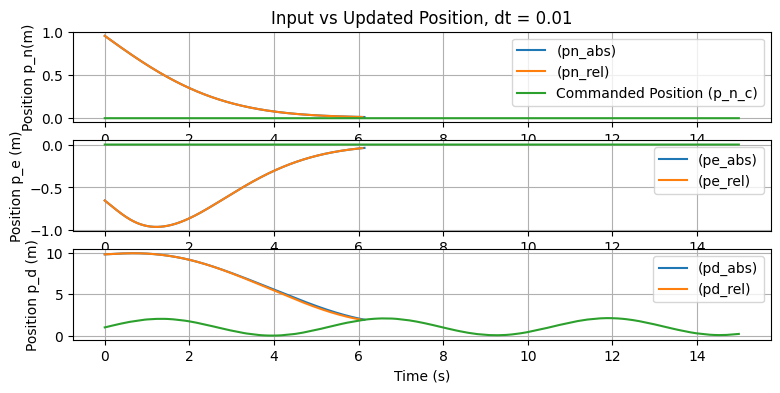

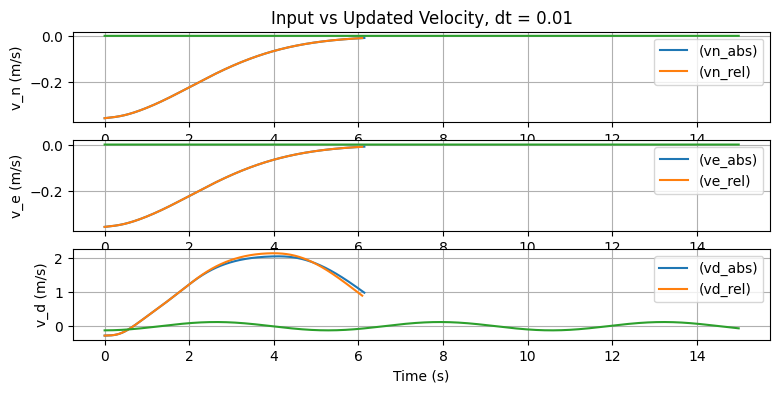

In [54]:
time_abs = np.arange(len(pos_abs[0])) * 0.01
time_rel = np.arange(len(pos_rel[0]))*0.01
time_ship = np.arange(len(ship_pos_test_data[0]))*0.01

# reshape the data
pos_abs = np.array(pos_abs[0])
pos_rel = np.array(pos_rel[0])
vel_abs = np.array(vel_abs[0])
vel_rel = np.array(vel_rel[0])

a = np.array(ship_pos_test_data[0])
b = np.array(ship_vel_test_data[0])


# create fig to compare two trajectories
# POSITION 
plt.figure(figsize=(9, 4))
plt.subplot(3, 1, 1)
plt.plot(time_abs, pos_abs[:, 0, 0], label='(pn_abs)')
plt.plot(time_rel, pos_rel[:, 0, 0], label='(pn_rel)')
# Plot the step input acceleration (input)
plt.plot(time_ship, a[:,0,0], label='Commanded Position (p_n_c)')
plt.title('Input vs Updated Position, dt = 0.01')
plt.xlabel('Time (s)')
plt.ylabel('Position p_n(m)')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(time_abs, pos_abs[:, 0, 1], label='(pe_abs)')
plt.plot(time_rel, pos_rel[:, 0, 1], label='(pe_rel)')
plt.plot(time_ship, a[:,0,1])
plt.xlabel('Time (s)')
plt.ylabel('Position p_e (m)')
plt.legend()
plt.grid(True)


plt.subplot(3, 1, 3)
plt.plot(time_abs, -pos_abs[:, 0, 2], label='(pd_abs)')
plt.plot(time_rel, -pos_rel[:, 0, 2], label='(pd_rel)')
plt.plot(time_ship, -a[:,0,2])
plt.xlabel('Time (s)')
plt.ylabel('Position p_d (m)')
plt.legend()
plt.grid(True)


# VELOCITY
plt.figure(figsize=(9, 4))
plt.subplot(3, 1, 1)
plt.plot(time_abs, vel_abs[:, 0, 0], label='(vn_abs)')
plt.plot(time_rel, vel_rel[:, 0, 0], label='(vn_rel)')
plt.plot(time_ship, b[:,0,0])
# Plot the step input acceleration (input)
# plt.step(time_array, traj_array[:, 1], label='Commanded Position (p_y_c)', where='post')
plt.title('Input vs Updated Velocity, dt = 0.01')
plt.xlabel('Time (s)')
plt.ylabel('v_n (m/s)')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(time_abs, vel_abs[:, 0, 0], label='(ve_abs)')
plt.plot(time_rel, vel_rel[:, 0, 0], label='(ve_rel)')
plt.plot(time_ship, b[:,0,1])
# Plot the step input acceleration (input)
# plt.step(time_array, traj_array[:, 1], label='Commanded Position (p_y_c)', where='post')
# plt.title('Input vs Updated Acceleration, dt = 0.01')
plt.xlabel('Time (s)')
plt.ylabel('v_e (m/s)')
plt.legend()
plt.grid(True)


plt.subplot(3, 1, 3)
plt.plot(time_abs, vel_abs[:, 0, 2], label='(vd_abs)')
plt.plot(time_rel, vel_rel[:, 0, 2], label='(vd_rel)')
plt.plot(time_ship, b[:,0,2])
# Plot the step input acceleration (input)
# plt.step(time_array, traj_array[:, 1], label='Commanded Position (p_y_c)', where='post')
plt.xlabel('Time (s)')
plt.ylabel('v_d (m/s)')
plt.legend()
plt.grid(True)











save the lists

csv

In [ ]:
import csv

def save_data_csv(data_lists, filenames):
    for data_list, filename in zip(data_lists, filenames):
        with open(filename, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerows(data_list)

# Save data
file_names = ['reward_rel_vel_z.csv', 'reward_touchdown_velocity.csv', 'reward_mean_time_to_col.csv']
save_data_csv([reward_rel_vel_z_list, reward_touchdown_velocity_list, reward_mean_time_to_col_list], file_names)

# Save data
save_data(reward_rel_vel_z_list, reward_touchdown_velocity_list, reward_mean_time_to_col_list, filename='my_data.pkl')


# Load data
loaded_data = load_data(filename='my_data.pkl')

pickle

In [51]:
import pickle

def save_data(*args, filename='data.pkl'):
    with open(filename, 'wb') as file:
        pickle.dump(args, file)

def load_data(filename='data.pkl'):
    with open(filename, 'rb') as file:
        return pickle.load(file)


# Save data
# save_data(rel_vel_list, time_to_col_list, dev_center_list, filename='final_data.pkl')
save_data(z_positions, filename= 'sine_wave_test_pid.pkl')


# Drone model for the PID

In [56]:
class VSQP_TF_4th_PID:
    def __init__(self,
                 num_envs,
                 start_pos, 
                 time_step):

        self.pos = start_pos
        # self.states = np.array([self.random_init() for _ in range(num_envs)])
        self.dt  = time_step   
        self.updated_states_drone = np.zeros(9)
        self.num_envs = num_envs
        self.ax_lim = np.array([1,1,1])
        self.buffer_size = 4
        # self.updated_states = np.zeros_like(self.states)
        self.past_actions  = np.zeros((num_envs,self.buffer_size,3))

    def add_action(self, new_action):
         # Add the new action at the end of the buffer if there is space
        if self.past_actions.shape[1] < self.buffer_size:
            self.past_actions = np.append(self.past_actions, new_action[:, None, :], axis=1)
        else:
            # If buffer is full, remove the oldest (first) action and append the new action at the end
            self.past_actions = np.roll(self.past_actions, -1, axis=1)
            self.past_actions[:, -1, :] = new_action



    def acc_differentiation(self, actions):

        # self.past_actions = np.roll(self.past_actions, -1, axis=0)
        # self.past_actions[-1, :] = actions
        if self.past_actions.shape[1] < self.buffer_size:
            self.past_actions = np.append(self.past_actions, actions[:, None, :], axis=1)
        else:
            # If buffer is full, remove the oldest (first) action and append the new action at the end
            self.past_actions = np.roll(self.past_actions, -1, axis=1)
            self.past_actions[:, -1, :] = actions

        # Compute the first, second, and third derivatives of the actions using finite differences
        jerk = (self.past_actions[:, -1, :] - self.past_actions[:, -2, :]) / self.dt
        snap = (self.past_actions[:, -1, :] - 2 * self.past_actions[:, -2, :] + self.past_actions[:, -3, :]) / self.dt**2
        crackle = (self.past_actions[:, -1, :]- 3 * self.past_actions[:, -2, :] + 3 * self.past_actions[:, -3, :] - self.past_actions[:, -4, :]) / self.dt**3

        return jerk, snap, crackle


    def update(self, states, actions):
        # do not keep track of the updated states in this class
        # assume that max accelearions are in between -3 and 3
        ## de-normalize the acceleration
        # denorm_ax = (actions[:,0] + 1)/2*(self.ax_lim[0] + self.ax_lim[0]) - self.ax_lim[0]
        # denorm_ay = (actions[:,1] + 1)/2*(self.ax_lim[1] + self.ax_lim[1]) - self.ax_lim[1]
        # denorm_az = (actions[:,2] + 1)/2*(self.ax_lim[2] + self.ax_lim[2]) - self.ax_lim[2]
        de_acc = np.stack([actions[0], actions[1], actions[2]]).T
        # de_acc = np.stack([actions[0], actions[1], actions[2]]).T

        # # call differentiation to calculate the acc derivatives
        der1_acc, der2_acc, der3_acc = self.acc_differentiation(actions)
        der1_acc = der1_acc.reshape(1,3)
        der2_acc = der2_acc.reshape(1,3)
        der3_acc = der3_acc.reshape(1,3)
        de_acc = de_acc.reshape(1,3)

        # Anorth and Aeast
        der6_Y_ne = 793*de_acc[:,0:2] + 203.6*der1_acc[:,0:2] + 0.0008596*der2_acc[:,0:2] + -9.477*10**-7*der3_acc[:,0:2] - 19.89*states[:,15:17] - 139.5* states[:,12:14] - 633.2*states[:,9:11] - 793.2*states[:,6:8]
        # der6_Y_d = 318.9*de_acc[:,2] + 956.8*der1_acc[:,2] + 2870*der2_acc[:,2] + 678.6*der3_acc[:,2] - 24.42*states[:,23] - 223.6*states[:,20] - 1157*states[:,17] - 3030* states[:,14] - 1010*states[:,11] - 318.9*states[:,8]
        der6_Y_d =793*de_acc[:,2] + 203.6*der1_acc[:,2] + 0.0008596*der2_acc[:,2] + -9.477*10**-7*der3_acc[:,2] - 19.89*states[:,17] - 139.5* states[:,14] - 633.2*states[:,11] - 793.2*states[:,8]
        # der6_Y_d_reshape = der6_Y_d.reshape(1,-1)
        # combine both derivatives - use tf of the ne
        der4_Acc = np.column_stack((der6_Y_ne, der6_Y_d))
        # assume derivatives of u are zero
        updated_pos = states[:,0:3] + states[:,3:6]*self.dt
        updated_vel = states[:,3:6] + states[:,6:9]*self.dt
        updated_acc = states[:,6:9] + states[:,9:12]*self.dt # real acceleration response of the ac
        der_1 = states[:,9:12] + states[:,12:15]*self.dt
        der_2 = states[:,12:15] + states[:,15:18]*self.dt
        der_3 = states[:,15:18] + der4_Acc*self.dt


        # Accelerations to Euler Angles
        # pitch
        g = 9.81
        euler_angles = np.zeros_like(updated_acc)
        # if an >0
        euler_angles[updated_acc[:,0]>=0,1] = 0 
        # if an <0
        euler_angles[updated_acc[:,0]< 0,1] = np.arcsin(-updated_acc[updated_acc[:,0]<=0,1]/g)
        # euler_angles[updated_acc[:,0]< 0,1] = 0.5


        # roll
        euler_angles[:,0] = np.arcsin(updated_acc[:,1]/g)
        # euler_angles[:,0] = 0.5
        # psi - this is already done

        return updated_pos, updated_vel, updated_acc, der_1, der_2, der_3, euler_angles
    
    def reset_(self,num_reset):

        x0 = np.random.uniform(-1,1, size=(num_reset,)) + self.pos[0]
        y0 = np.random.uniform(-1,1, size=(num_reset,)) + self.pos[1]
        z0 = np.random.uniform(-1,1, size=(num_reset,)) + self.pos[2]
        
        vx0 = np.random.uniform(-0.5,0.5, size=(num_reset,))
        vy0 = np.random.uniform(-0.5,0.5, size=(num_reset,))
        vz0 = np.random.uniform(-0.5,0.5, size=(num_reset,))

        ax0 = np.random.uniform(-0.05,0.05, size=(num_reset,))
        ay0 = np.random.uniform(-0.05,0.05, size=(num_reset,))
        az0 = np.random.uniform(-0.05,0.05, size=(num_reset,))

        # euler angles
        phi0 = np.random.uniform(-0.05,0.05, size=(num_reset,))
        the0 = np.random.uniform(-0.05,0.05, size=(num_reset,))
        psi0 = np.random.uniform(-0.05,0.05, size=(num_reset,))

        # Create an array of zeros with the shape (num_reset, 15) for the additional derivatives + 3 for the derivatives of accelerations
        zero_der_array = np.zeros((num_reset, 9))

        # Group them in threes (position, velocity, acceleration)
        # zero initial conditions
        positions = np.stack((x0, y0, z0), axis=-1)
        velocities = np.stack((vx0, vy0, vz0), axis=-1)
        accelerations = np.stack((ax0, ay0, az0), axis=-1)
        euler_angles = np.stack((phi0, the0, psi0), axis=-1)
        # Now, stack these groups along with the zero array to form the final state array
        stacked_states = np.hstack((positions, velocities, accelerations, zero_der_array, euler_angles))

        # modify it in a way that it includes the derivatives(zero given)
        # stacked_states = np.stack([x0, y0, z0, vx0, vy0, vz0,ax0, ay0, az0, zero_der_array ]).T
        return stacked_states

# PID CLASS

In [69]:
class PID_VSQP:
    def __init__(self):
        self.Kp_pos = 0.33
        # self.Ki_pos = 0.25
        self.Kp_vel = 0.89
        # self.Kd_vel = 1.43

        # init der and int values
        self.err_pos_int = 0
        self.err_vel_der = 0

    def err_cont(self, ship_pos, drone_pos, drone_vel):

        # err pos
        err_pos = ship_pos - drone_pos # current error
        # area = (err_pos + self.err_pos_int)/2 * 0.01
        # err_pos_int = self.err_pos_int + area
        # self.err_pos_int = err_pos_int

        un_sat_vel_c = err_pos*self.Kp_pos 
        sat_vel_c = np.clip(un_sat_vel_c, -2, 2)

        # err vel
        err_vel = sat_vel_c - drone_vel
        # err_vel_der = (err_vel - self.err_vel_der)/0.01
        un_sat_acc_c = err_vel*self.Kp_vel 
        sat_acc_c = np.clip(un_sat_acc_c, -1, 1)
        # self.err_vel_der = err_vel_der

        # response of the drone

        return sat_acc_c.reshape(3,), sat_vel_c

num_envs = 1
# # test case 2
# start_amps_t2 = np.array([50,2,-1])
# freqs_t2 = np.array([0,0,0.05]) 
# start_platform_pos = np.array([0,0,-1])
# platform_simulator_pid = PlatformSimulator3D_test(num_envs=num_envs, start_amps=start_amps_t2, frequency=freqs_t2, start_platform_pos=start_platform_pos)


# run the pid controller
# 
pid_log = logs[f'log_name{10}']
 # Extract data
RL_pnd, RL_ped, RL_pdd = pid_log['xd'], pid_log['yd'], pid_log['zd']
RL_vnd, RL_ved, RL_vdd = pid_log['vnd'], pid_log['ved'], pid_log['vdd']
RL_and, RL_aed, RL_add = pid_log['and'], pid_log['aed'], pid_log['add']
# pns, pes, pds = pid_log['xs'], pid_log['ys'], pid_log['zs']
# vns, ves, vds = pid_log['vns'], pid_log['ves'], pid_log['vds']


time_step = 0.01
start_drone_pos = np.array([RL_pnd[0], RL_ped[0], RL_pdd[0]])
start_drone_vel = np.array([RL_vnd[0], RL_ved[0], RL_vdd[0]])
start_drone_acc = np.array([RL_and[0], RL_aed[0], RL_add[0]])
agent_4th = VSQP_TF_4th_PID(num_envs=num_envs, start_pos=start_drone_pos, time_step=time_step)

# reset the system to get initial states
states_4th = agent_4th.reset_(num_reset=num_envs)
states_4th[:,0:3] = start_drone_pos
states_4th[:,3:6] = start_drone_vel
states_4th[:,6:9] = start_drone_acc

# ## zero initial conditions
# states_4th[:,0:3] = np.array([0, 0, 0])
# states_4th[:,3:6] = np.array([0,0, 0])
# states_4th[:,6:9] = np.array([0, 0, 0])

# start_drone_pos = np.array([0, 0, 0])
# start_drone_vel = np.array([0, 0, 0])


# list for the 4th order tf with PID
pos_pid = []
vel_pid = []
acc_pid = []
pid_cont = []
vel_cont = []
traj = []
ship_vel_list = []
pid_agent = PID_VSQP()

dt = 0.01

# time = np.arange(0, len(pns)*dt, dt)
num_steps = 1500

# 1st case step response
for step in range(num_steps):
    # ship_pos = np.array([1,0,0]) if step > 1 else np.array([0,0,0])
    # ship_pos = np.array([pns[step], pes[step], pds[step]])
    # ship_pos, vel = platform_simulator_pid.update()
    ship_pos, ship_vel = ship_pos_test_data[0][step], ship_vel_test_data[0][step]
    ship_pos = ship_pos.reshape(3,)

    rel_Vel  = start_drone_vel - ship_vel
    acc_com_pid, vel_c = pid_agent.err_cont(ship_pos=ship_pos, drone_pos=start_drone_pos, drone_vel=rel_Vel)

    # update the system with 4th
    updated_pos_4th, updated_vel_4th, updated_acc_4th, der_1_4th, der_2_4th, der_3_4th, euler_angles= agent_4th.update(states_4th, acc_com_pid)

    # if drone_pos > ship_pos : platform collision
    if -updated_pos_4th[:,2] < -ship_pos[2]:
        print("collision happened!!" + "at" , step)
        print("relative velocity", np.abs(rel_Vel[:,2]) )
        break
    
    # Store the updated states
    pos_pid.append(updated_pos_4th)
    vel_pid.append(updated_vel_4th)
    acc_pid.append(updated_acc_4th)
    pid_cont.append(acc_com_pid)
    vel_cont.append(vel_c)
    traj.append(ship_pos)
    ship_vel_list.append(ship_vel)

    start_drone_pos = updated_pos_4th
    start_drone_vel = updated_vel_4th


    # Prepare states for the next step
    states_4th = np.hstack((updated_pos_4th, updated_vel_4th, updated_acc_4th, der_1_4th, der_2_4th, der_3_4th, euler_angles))


# Convert lists to numpy arrays for plotting
positions_4th = np.array(pos_pid)
velocities_4th = np.array(vel_pid)
accelerations_4th = np.array(acc_pid)
acc_commanded = np.array(pid_cont)
# vel_commanded = np.array(vel_cont)
traj_array = np.array(traj)
ship_vel_array = np.array(ship_vel_list)


print('drone_pos_last_min', positions_4th[-1,0,2] )
print('ship_pos', traj_array[-1,2] )

# save data
save_data(positions_4th, filename= 'test_pos_rel')
save_data(velocities_4th, filename= 'test_vel_rel')



collision happened!!at 610
relative velocity [0.96393343]
drone_pos_last_min -1.9064258337973705
ship_pos -1.8968080921059027


# PID for more then one scenario

In [34]:
num_envs = 1
# test case 2
start_amps_t2 = np.array([50,2,-1])
freqs_t2 = np.array([0,0,0.05]) 
start_platform_pos = np.array([0,0,-1])

# lists for all the environments
envs_pos_pid = []
envs_vel_pid = []
envs_acc_pid = []
envs_traj_pid  = []
reward_rel_vel_z_pid = []
reward_dev_xy_pid = []
reward_ttc_pid = []

for i in range(100): # for the number of environments

    platform_simulator_pid = PlatformSimulator3D_test(num_envs=num_envs, start_amps=start_amps_t2, frequency=freqs_t2, start_platform_pos=start_platform_pos)


    # run the pid controller
    # 
    pid_log = logs[f'log_name{i}']
    # Extract data
    RL_pnd, RL_ped, RL_pdd = pid_log['xd'], pid_log['yd'], pid_log['zd']
    RL_vnd, RL_ved, RL_vdd = pid_log['vnd'], pid_log['ved'], pid_log['vdd']
    RL_and, RL_aed, RL_add = pid_log['and'], pid_log['aed'], pid_log['add']
    # pns, pes, pds = pid_log['xs'], pid_log['ys'], pid_log['zs']
    # vns, ves, vds = pid_log['vns'], pid_log['ves'], pid_log['vds']


    time_step = 0.01
    start_drone_pos = np.array([RL_pnd[0], RL_ped[0], RL_pdd[0]])
    start_drone_vel = np.array([RL_vnd[0], RL_ved[0], RL_vdd[0]])
    start_drone_acc = np.array([RL_and[0], RL_aed[0], RL_add[0]])
    agent_4th = VSQP_TF_4th_PID(num_envs=num_envs, start_pos=start_drone_pos, time_step=time_step)

    # reset the system to get initial states
    states_4th = agent_4th.reset_(num_reset=num_envs)
    states_4th[:,0:3] = start_drone_pos
    states_4th[:,3:6] = start_drone_vel
    states_4th[:,6:9] = start_drone_acc

    # list for the 4th order tf with PID
    pos_pid = []
    vel_pid = []
    acc_pid = []
    pid_cont = []
    vel_cont = []
    rel_vel_z = []
    traj = []
    ship_vel = []
    pid_agent = PID_VSQP()

    dt = 0.01

    num_steps = 1500

    # 1st case step response
    for step in range(num_steps):
        # ship_pos = np.array([1,0,0]) if step > 1 else np.array([0,0,0])
        # ship_pos = np.array([pns[step], pes[step], pds[step]])
        ship_pos, vel = platform_simulator_pid.update()
        ship_pos = ship_pos.reshape(3,)

        start_drone_vel = start_drone_vel - vel
        acc_com_pid, vel_c = pid_agent.err_cont(ship_pos=ship_pos, drone_pos=start_drone_pos, drone_vel=start_drone_vel)

        # update the system with 4th
        updated_pos_4th, updated_vel_4th, updated_acc_4th, der_1_4th, der_2_4th, der_3_4th, euler_angles= agent_4th.update(states_4th, acc_com_pid)

        # if drone_pos > ship_pos : platform collision
        if -updated_pos_4th[:,2] < -ship_pos[2]:
            print("collision happened!!" + "at" , step)
            break
        
        # Store the updated states
        pos_pid.append(updated_pos_4th)
        vel_pid.append(updated_vel_4th)
        acc_pid.append(updated_acc_4th)
        pid_cont.append(acc_com_pid)
        vel_cont.append(vel_c)
        traj.append(ship_pos)
        ship_vel.append(vel)
       
        

        start_drone_pos = updated_pos_4th
        start_drone_vel = updated_vel_4th


        # Prepare states for the next step
        states_4th = np.hstack((updated_pos_4th, updated_vel_4th, updated_acc_4th, der_1_4th, der_2_4th, der_3_4th, euler_angles))


    envs_pos_pid.append(pos_pid)
    envs_vel_pid.append(vel_pid)
    envs_acc_pid.append(acc_pid)
    envs_traj_pid.append(traj)
    reward_rel_vel_z_pid.append(np.abs(vel_pid[-1][0][2] - ship_vel[-1][0][2]))
    reward_dev_xy_pid.append(np.sqrt((pos_pid[-1][0][0] - traj[-1][0])**2 + (pos_pid[-1][0][1] - traj[-1][1])**2  ))
    reward_ttc_pid.append(len(pos_pid))

print('rel_vel_mean', np.mean(reward_rel_vel_z_pid))
print('dev_xy_mean', np.mean(reward_dev_xy_pid))
print('ttc_mean', np.mean(reward_ttc_pid))




collision happened!!at 782
collision happened!!at 941
collision happened!!at 816
collision happened!!at 617
collision happened!!at 762
collision happened!!at 869
collision happened!!at 987
collision happened!!at 902
collision happened!!at 613
collision happened!!at 1086
collision happened!!at 806
collision happened!!at 949
collision happened!!at 865
collision happened!!at 680
collision happened!!at 639
collision happened!!at 930
collision happened!!at 729
collision happened!!at 561
collision happened!!at 874
collision happened!!at 967
collision happened!!at 595
collision happened!!at 670
collision happened!!at 540
collision happened!!at 922
collision happened!!at 620
collision happened!!at 746
collision happened!!at 1024
collision happened!!at 838
collision happened!!at 676
collision happened!!at 1034
collision happened!!at 849
collision happened!!at 620
collision happened!!at 655
collision happened!!at 992
collision happened!!at 853
collision happened!!at 625
collision happened!!at 91

save PID 

In [33]:
import pickle

def save_data(*args, filename='data.pkl'):
    with open(filename, 'wb') as file:
        pickle.dump(args, file)


# Save data
save_data(reward_rel_vel_z_pid, reward_dev_xy_pid, reward_ttc_pid, filename='pid_smooth_abs_mix.pkl')

# Plot the response of the PID controller

Position

In [ ]:
# Generate a time array in seconds
time_array = np.arange(len(traj)) * time_step

plt.style.use("default")
plt.figure(figsize=(6, 4))
for i in range(100):
    traj_array = np.array(envs_traj_pid[i])
    time_array = np.arange(len(traj_array)) * time_step
    # sin z  
    plt.plot(time_array, -traj_array[:, 2], label='z motion')
    plt.xlabel('Time (s)')
    plt.ylabel('Position p_d(m)')
    plt.legend()
    plt.grid(True)

# POSITION 
plt.figure(figsize=(6, 4))

plt.subplot(3, 1, 1)
plt.plot(time_array, positions_4th[:, 0, 0], label='(p_n)')
# Plot the step input acceleration (input)
plt.plot(time_array, traj_array[:, 0], label='Commanded Position (p_n_c)')
plt.title('Input vs Updated Position, dt = 0.01')
plt.xlabel('Time (s)')
plt.ylabel('Position p_n(m)')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(time_array, positions_4th[:, 0, 1], label='(p_e)')
# Plot the step input acceleration (input)
plt.plot(time_array, traj_array[:, 1], label='Commanded Position (p_e_c)')
plt.xlabel('Time (s)')
plt.ylabel('Position p_e (m)')
plt.legend()
plt.grid(True)


plt.subplot(3, 1, 3)
plt.plot(time_array, positions_4th[:, 0, 2], label=' (p_d)')
# Plot the step input acceleration (input)
plt.plot(time_array, traj_array[:, 2], label='Commanded Position (p_d_c)')
plt.xlabel('Time (s)')
plt.ylabel('Position p_d (m)')
plt.legend()
plt.grid(True)


# VELOCITY
plt.figure(figsize=(6, 4))
plt.subplot(3, 1, 1)
plt.plot(time_array, velocities_4th[:, 0, 0], label='Updated Velocity')
# Plot the step input acceleration (input)
# plt.step(time_array, traj_array[:, 1], label='Commanded Position (p_y_c)', where='post')
plt.title('Input vs Updated Velocity, dt = 0.01')
plt.xlabel('Time (s)')
plt.ylabel('v_n (m/s)')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(time_array, velocities_4th[:, 0, 1], label='Updated Velocity')
# Plot the step input acceleration (input)
# plt.step(time_array, traj_array[:, 1], label='Commanded Position (p_y_c)', where='post')
# plt.title('Input vs Updated Acceleration, dt = 0.01')
plt.xlabel('Time (s)')
plt.ylabel('v_e (m/s)')
plt.legend()
plt.grid(True)


plt.subplot(3, 1, 3)
plt.plot(time_array, velocities_4th[:, 0, 2], label='Updated Velocity')
# Plot the step input acceleration (input)
# plt.step(time_array, traj_array[:, 1], label='Commanded Position (p_y_c)', where='post')
plt.xlabel('Time (s)')
plt.ylabel('v_d (m/s)')
plt.legend()
plt.grid(True)

# ACCELERATIONS
plt.figure(figsize=(6, 4))
plt.subplot(3, 1, 1)
plt.plot(time_array, accelerations_4th[:, 0, 0], label='Updated Acceleration', linewidth=2)
# Plot the step input acceleration (input)
plt.step(time_array, acc_commanded[:, 0], label='Commanded Acceleration (p_z_c)')
plt.title('Input vs Updated Position, dt = 0.01')
plt.xlabel('Time (s)')
plt.ylabel('a_n (m/s^2)')
# plt.legend(["2nd", "2nd_dc", "6th"])
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(time_array, accelerations_4th[:, 0, 1], label='Updated Acceleration', linewidth=2)
# Plot the step input acceleration (input)
plt.step(time_array, acc_commanded[:, 1], label='Commanded Acceleration (p_z_c)')
plt.xlabel('Time (s)')
plt.ylabel('a_e (m/s^2)')
# plt.legend(["2nd", "2nd_dc", "6th"])
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(time_array, accelerations_4th[:, 0, 0], label='Updated ', linewidth=2)
# Plot the step input acceleration (input)
plt.step(time_array, acc_commanded[:, 2], label='Commanded')
plt.xlabel('Time (s)')
plt.ylabel('a_d (m/s)')
# plt.legend(["2nd", "2nd_dc", "6th"])
plt.legend()
plt.grid(True)




plt.tight_layout()
plt.show()


# Create a data set from a real ship data

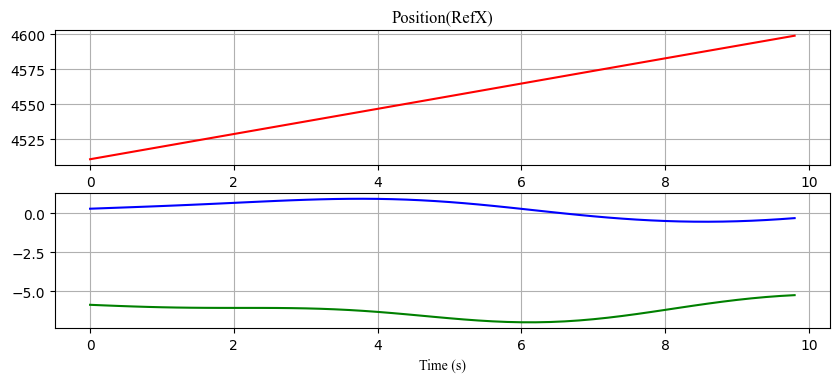

In [8]:
## THIS INCORPARATES REAL SHIP DATA
import pandas as pd
import numpy as np

class PlatformSimulator3D():
    def __init__(self, csv_filepath, edge_length=5.0):
        self.position = np.array([0.0, 0.0, 0.0])  # Initial position (x, y, z)
        self.ori = np.array([0.0, 0.0, 0.0])  # Initial position (x, y, z)
        self.edge_length = edge_length
        self.heading = 0.0  # Initial yaw angle in radians
        self.pitch = 0.0  # Initial pitch angle in radians
        self.roll = 0.0  # Initial roll angle in radians
        self.time = 0.0  # Simulation time
        self.time_step = 0 # 

        # 
        self.data = pd.read_csv(csv_filepath)
        self.translation = self.data[['RefX', 'RefY', 'RefZ']].values
        self.rotation = self.data[['Roll', 'Pitch', 'Yaw']].values
        self.current_index = 0  # Current index for the data arrays
        

    def update(self, delta_time):
        self.time += delta_time

        # # Simple movement model with sinusoidal signals for position
        # self.position[0] = np.sin(self.time) * 2  # Sinusoidal signal for x
        # self.position[1] = np.sin(self.time) * 2  # Sinusoidal signal for y

        # # Sinusoidal changes for Euler angles
        # self.heading = np.sin(self.time * 0.5) * np.pi / 4  # Yaw
        # self.pitch = np.sin(self.time * 0.7) * np.pi / 6  # Pitch
        # self.roll = np.sin(self.time * 0.9) * np.pi / 8  # Roll

        #
        self.position = self.translation[self.current_index]
        self.ori = self.rotation[self.current_index]
        self.roll, self.pitch, self.yaw = self.rotation[self.current_index]
            
        # Increment the index and time for the next update
        self.current_index += 1


        return self.position, self.heading, self.pitch, self.roll, self.ori


# creata an instance of a class
simulator = PlatformSimulator3D('run_8.csv')

# empty lists for the position 
pos_list = []
num_steps = 50

for i in range(num_steps):
    position, heading, pitch, roll, osi = simulator.update(0.2)
    pos_list.append(position)


pos_array = np.array(pos_list)

# Sampling interval
sampling_interval = 0.2  # seconds

# Time axis
time_steps = [i * sampling_interval for i in range(len(pos_array))]

# Create subplots
plt.figure(figsize=(10,6))

plt.subplot(3, 1, 1)
plt.plot(time_steps, pos_array[:,0], 'r-', linewidth=1.5)
plt.title('Position(RefX)', fontname='Times New Roman', fontsize=12)
plt.xlabel('Time (s)', fontname='Times New Roman', fontsize=10)
plt.grid(True)
#plt.ylabel('refx (m)', fontname='Times New Roman', fontsize=10)

plt.subplot(3,1,2)
plt.plot(time_steps, pos_array[:,1], 'b-', linewidth=1.5, label = 'RefY')
plt.plot(time_steps, pos_array[:,2], 'g-', linewidth=1.5, label = 'RefZ')
plt.xlabel('Time (s)', fontname='Times New Roman', fontsize=10)
#lt.legend('RefY', 'RefZ')
#plt.ylabel('', fontname='Times New Roman', fontsize=10)
plt.grid(True)



# Running Multiple Environments


In [ ]:
max_steps = 10000

test_env = VSQP_ship_landing(num_envs=1,
                             start_drone_pos= start_drone_pos,
                             start_platform_pos=start_platform_pos,
                             dt=0.01, 
                             start_amps=start_amps, 
                             freqs=freqs)

# path = 'models/RL_ship_landing/RL_ship_landing_v28/5000000'
path = 'models/tez_const_z/v_37/12000000'
model = PPO.load(path)

test_env.reset()

# time_mv = []
# states_drone_mv = []
# states_ship_mv = []
# action_list_mv = []
# states_RL_mv = []



def run_simultaneous_environments(num_envs, model, test_env):
    # Initialize tracking for active environments
    active_environments = [True] * num_envs
    global states_RL_mv , states_drone_mv, states_ship_mv, action_list_mv, time_mv 
    states_RL_mv = [[] for _ in range(num_envs)]
    states_drone_mv = [[] for _ in range(num_envs)]
    states_ship_mv = [[] for _ in range(num_envs)]
    action_list_mv = [[] for _ in range(num_envs)]
    time_mv = [[] for _ in range(num_envs)]

    # Continue looping until all environments are done
    while any(active_environments):
        for env in range(num_envs):
            if active_environments[env]:  # Only update if the environment is still active
                actions, _ = model.predict(test_env.states, deterministic=False)
                states, rewards, done, infos = test_env.step(actions)
                animation_tez.view(test_env.render())
                # Append data for each environment
                states_RL_mv[env].append(states.copy())
                states_drone_mv[env].append(test_env.world_states_drone.copy())
                states_ship_mv[env].append(test_env.world_states_ship.copy())
                action_list_mv[env].append(actions.copy())
                time_mv[env].append(test_env.step_counts * test_env.dt)

                if done:
                    active_environments[env] = False  # Mark this environment as done
                    print('Environment', env, 'done:', infos)
                
                
    
num_envs = 5
run_simultaneous_environments(num_envs, model,test_env)


# Logging 

In [ ]:
# make log dict
log_dict = {}

# Assuming the outer list index is environment and inner list index is time step
# Convert each list of lists to an array per environment
log_dict['t'] = [np.array(times) for times in time_mv]

# Handle RL states: assuming each state component is stored in separate list entries
log_dict['s1'] = [np.array([state[:,0] for state in env_states]) for env_states in states_RL_mv]
log_dict['s2'] = [np.array([state[:,1] for state in env_states]) for env_states in states_RL_mv]
log_dict['s3'] = [np.array([state[:,2] for state in env_states]) for env_states in states_RL_mv]
log_dict['s4'] = [np.array([state[:,3] for state in env_states]) for env_states in states_RL_mv]
log_dict['s5'] = [np.array([state[:,4] for state in env_states]) for env_states in states_RL_mv]
log_dict['s6'] = [np.array([state[:,5] for state in env_states]) for env_states in states_RL_mv]



# states drone
log_dict['xd']   = [np.array([state[:,0] for state in env_states]) for env_states in states_drone_mv]
log_dict['yd']   = [np.array([state[:,1] for state in env_states]) for env_states in states_drone_mv]
log_dict['zd']   = [np.array([state[:,2] for state in env_states]) for env_states in states_drone_mv]
log_dict['vnd']  = [np.array([state[:,3] for state in env_states]) for env_states in states_drone_mv]
log_dict['ved']  = [np.array([state[:,4] for state in env_states]) for env_states in states_drone_mv]
log_dict['vdd']  = [np.array([state[:,5] for state in env_states]) for env_states in states_drone_mv]
log_dict['and']  = [np.array([state[:,6] for state in env_states]) for env_states in states_drone_mv]
log_dict['aed']  = [np.array([state[:,7] for state in env_states]) for env_states in states_drone_mv]
log_dict['add']  = [np.array([state[:,8] for state in env_states]) for env_states in states_drone_mv]
log_dict['phid'] = [np.array([state[:,9] for state in env_states]) for env_states in states_drone_mv]
log_dict['thed'] = [np.array([state[:,10] for state in env_states]) for env_states in states_drone_mv]
log_dict['psid'] = [np.array([state[:,11] for state in env_states]) for env_states in states_drone_mv]

# states ship
log_dict['xs']   = [np.array([state[:,0] for state in env_states]) for env_states in states_ship_mv]
log_dict['ys']   = [np.array([state[:,1] for state in env_states]) for env_states in states_ship_mv]
log_dict['zs']   = [np.array([state[:,2] for state in env_states]) for env_states in states_ship_mv]
log_dict['vns']  = [np.array([state[:,3] for state in env_states]) for env_states in states_ship_mv]
log_dict['ves']  = [np.array([state[:,4] for state in env_states]) for env_states in states_ship_mv]
log_dict['vds']  = [np.array([state[:,5] for state in env_states]) for env_states in states_ship_mv]
# actions 
log_dict['u1'] = [np.array([state[:,0] for state in env_states]) for env_states in action_list_mv]
log_dict['u2'] = [np.array([state[:,1] for state in env_states]) for env_states in action_list_mv]
log_dict['u3'] = [np.array([state[:,2] for state in env_states]) for env_states in action_list_mv]
#log_dict['u'] = np.stack([log_dict['u1'], log_dict['u2'], log_dict['u3']], axis=1)

In [ ]:
print((len(log_dict['s1'][0])))

# Load the dict

In [ ]:
# load the dict
# log_dict_tez_case_37_12 = dict(np.load('flight_data/tez_sim_logs/tez_case37_12.npz'))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotting trajectory
ax.plot(log_dict['s1'][0], log_dict['s2'][0], -1*log_dict['s3'][0], label='UAV Trajectory', marker='.')

ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')
ax.set_title('3D Trajectory and Landing Platform')
ax.legend()

# Plot state variables

In [ ]:
def plot_vel_pos(log_dict):
    
    dt = 0.01
    # Extract data
    pnd, ped, pdd = log_dict['xd'][1], log_dict['yd'][1], log_dict['zd'][1]
    vnd, ved, vdd = log_dict['vnd'][1], log_dict['ved'][1], log_dict['vdd'][1]
   
     # Create the time array
    time = np.arange(0, len(pnd)*dt , dt)

    # Separate plots for each acceleration component
    plt.figure(figsize=(10, 4))
    titles = ['Position in NED', 'Velocity in NED' ]
    labels = [(' p_n', 'p_e', 'p_d'), ('vn', 've', 'vd')]
    data_pairs = [(pnd, ped, pdd), (vnd, ved, vdd)]
    colors = ['red', 'blue', 'green']

    for i, ((p1, p2, p3), color, label) in enumerate(zip(data_pairs, colors, labels), 1):
        plt.subplot(2,1,i)
        plt.plot(time, p1, color = colors[0], linestyle = '--', linewidth = 1.5, label =label[0] )
        plt.plot(time, p2, color = colors[1], linewidth = 1.5, label = label[1])
        plt.plot(time, p3, color = colors[2], linewidth = 1.5, label = label[2])
        plt.xlabel('Time (s)', fontsize = 10)
        plt.ylabel(labels[i-1], fontsize = 10)
        plt.grid(True, linestyle = '--', alpha = 0.5)
        plt.legend()
        

    plt.tight_layout()
    plt.show()


plot_vel_pos(log_dict)